In [ ]:
import requests
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  KFold
import warnings
import re
warnings.filterwarnings('ignore')

# **Préparation des endpoints**

In [ ]:
api_key = "a7a0813f3d0ae3a4c26bf99545474eae"
api_base_url = "https://api.themoviedb.org/3"

discover_endpoint = f"{api_base_url}/discover/movie?api_key={api_key}&with_original_language=en"  

movie_endpoint = f"{api_base_url}/movie/"

def create_discover_endpoint(i,sort):
  return f"{discover_endpoint}&page={i}&sort_by={sort}"

def create_movie_endpoint(movie_id):
  return f"{movie_endpoint}{movie_id}?api_key={api_key}"

def create_credits_endpoint(movie_id):
  return f"{movie_endpoint}{movie_id}/credits?api_key={api_key}"


In [ ]:
requests.get(create_movie_endpoint(8967))

<Response [200]>

# **Récupération et sauvegarde des ids de films**

In [ ]:
ids=[]

movie_sorting = ["popularity.asc", "popularity.desc", "release_date.asc", "release_date.desc", "revenue.asc", "revenue.desc", "primary_release_date.asc", "primary_release_date.desc", "original_title.asc", "original_title.desc", "vote_average.asc", "vote_average.desc", "vote_count.asc", "vote_count.desc"]

for sort in movie_sorting :
  for i in range(1,501):
    r=requests.get(create_discover_endpoint(i,sort))
    for j in range(len(r.json()["results"])): 
      try:
        if r.json()["results"][j]["release_date"] != '' :
          ids.append(r.json()["results"][j]["id"])
      except :
        pass

In [ ]:
ids = set(ids)
len(ids)

62535

In [ ]:
with open('movies_ids.csv', 'w') as f:
    write = csv.writer(f)  
    write.writerow(list(ids))

# **Import des ids de films**

In [ ]:
with open('movies_ids.csv', 'r') as f:
    ids = f.readlines()

ids = ids[0].split(',')
ids = [int(x) for x in ids]

In [ ]:
print(len(ids))

63492


# **Récupération des infos sur les films**

In [ ]:
movies_db_columns=['id','title','budget','genres','original_language','overview','production_companies','release_date','revenue','runtime','vote_average','vote_count','actors','director','producers']
movies = []
pestiferes = []

for id in ids:
  print(id)
  r=requests.get(create_movie_endpoint(id))
  movie = r.json()
  
  try:
    if movie['budget']!=0 and movie['revenue']!=0:
      title = movie['title']
      
      budget = movie['budget']
      revenue = movie['revenue']
      genres = [movie['genres'][i].get('name') for i in range(len(movie['genres']))]
      original_language = movie['original_language']
      overview = movie['overview']
      production_companies = [movie['production_companies'][i].get('name') for i in range(len(movie['production_companies']))]
      release_date = movie['release_date']
      
      runtime = movie['runtime']
      vote_average = movie['vote_average']
      vote_count = movie['vote_count']

      r = requests.get(create_credits_endpoint(id))
      cast = r.json()['cast']
      try:
        actors = [cast[i] for i in range(5)]
      except IndexError:
        actors = [cast[i] for i in range(len(cast))]

      crew = r.json()['crew']

      directors = [crew[i]for i in range(len(crew)) if crew[i].get('job') == 'Director']
      producers = [crew[i] for i in range(len(crew)) if crew[i].get('job') == 'Producer']
      
      movies.append([id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,directors,producers])
    else:
      pestiferes.append([id,movie['title'],movie['budget'],movie['revenue']])
  except KeyError as e:
    print(e, id)



In [ ]:
len(movies)

7128

In [ ]:
movies_db = pd.DataFrame(movies,columns=movies_db_columns)
movies_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128 entries, 0 to 7127
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7128 non-null   int64  
 1   title                 7128 non-null   object 
 2   budget                7128 non-null   int64  
 3   genres                7128 non-null   object 
 4   original_language     7128 non-null   object 
 5   overview              7128 non-null   object 
 6   production_companies  7128 non-null   object 
 7   release_date          7128 non-null   object 
 8   revenue               7128 non-null   int64  
 9   runtime               7126 non-null   float64
 10  vote_average          7128 non-null   float64
 11  vote_count            7128 non-null   int64  
 12  actors                7128 non-null   object 
 13  director              7128 non-null   object 
 14  producers             7128 non-null   object 
dtypes: float64(2), int64(

In [ ]:
movies_db.head()

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers
0,5,Four Rooms,4000000,"[Crime, Comedy]",en,It's Ted the Bellhop's first night on the job....,"[Miramax, A Band Apart]",1995-12-09,4257354,98.0,5.7,2086,"[{'adult': False, 'gender': 2, 'id': 3129, 'kn...","[{'adult': False, 'gender': 1, 'id': 3110, 'kn...","[{'adult': False, 'gender': 2, 'id': 2545, 'kn..."
1,6,Judgment Night,21000000,"[Action, Thriller, Crime]",en,"While racing to a boxing match, Frank, Mike, J...","[Universal Pictures, Largo Entertainment, JVC]",1993-10-15,12136938,110.0,6.5,224,"[{'adult': False, 'gender': 2, 'id': 2880, 'kn...","[{'adult': False, 'gender': 2, 'id': 2042, 'kn...","[{'adult': False, 'gender': 2, 'id': 71417, 'k..."
2,11,Star Wars,11000000,"[Adventure, Action, Science Fiction]",en,Princess Leia is captured and held hostage by ...,"[Lucasfilm, 20th Century Fox]",1977-05-25,775398007,121.0,8.2,16675,"[{'adult': False, 'gender': 2, 'id': 2, 'known...","[{'adult': False, 'gender': 2, 'id': 1, 'known...","[{'adult': False, 'gender': 2, 'id': 12401, 'k..."
3,12,Finding Nemo,94000000,"[Animation, Family]",en,"Nemo, an adventurous young clownfish, is unexp...",[Pixar],2003-05-30,940335536,100.0,7.8,15985,"[{'adult': False, 'gender': 2, 'id': 13, 'know...","[{'adult': False, 'gender': 2, 'id': 7, 'known...","[{'adult': False, 'gender': 2, 'id': 9, 'known..."
4,13,Forrest Gump,55000000,"[Comedy, Drama, Romance]",en,A man with a low IQ has accomplished great thi...,"[Paramount, The Steve Tisch Company]",1994-07-06,677387716,142.0,8.5,22143,"[{'adult': False, 'gender': 2, 'id': 31, 'know...","[{'adult': False, 'gender': 2, 'id': 24, 'know...","[{'adult': False, 'gender': 1, 'id': 28, 'know..."


In [ ]:
movies_db.to_csv("movies_db.csv",index=False)

In [ ]:
movies_db.to_csv("movies_db_v2.csv",index=False)

NameError: ignored

# **Import de la base de données de films**

In [ ]:
movies_db = pd.read_csv("movies_db.csv", delimiter=",",engine='python')

In [ ]:
movies_db = pd.read_csv("movies_db_v2.csv", delimiter=",",engine='python',  error_bad_lines=False)

In [ ]:
movies_db.tail()

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers
7124,392982,Marshall,12000000,['Drama'],en,"Thurgood Marshall, the first African-American ...",['Chestnut Ridge'],2017-10-13,10051659,118.0,7.3,479.0,"[{'adult': False, 'gender': 2, 'id': 172069, '...","[{'adult': False, 'gender': 2, 'id': 68215, 'k...","[{'adult': False, 'gender': 1, 'id': 9183, 'kn..."
7125,261949,Thanks Maa,500000,"['Comedy', 'Drama']",en,"While on the run from the reformatory, a 12 ye...","['Quantum Films [in]', 'Sony Pictures']",2010-03-05,2000000,120.0,5.8,3.0,"[{'adult': False, 'gender': 0, 'id': 1305480, ...","[{'adult': False, 'gender': 0, 'id': 1265938, ...",[]
7126,78127,Silk Shoes,300,"['Comedy', 'Drama']",en,With his film having failed and producer havin...,[],2006-06-22,300,100.0,4.9,4.0,"[{'adult': False, 'gender': 2, 'id': 141857, '...","[{'adult': False, 'gender': 2, 'id': 96780, 'k...","[{'adult': False, 'gender': 2, 'id': 96780, 'k..."
7127,655232,Vazante,2424713,['Drama'],en,"On an empty beach, 5 kids talk and talk, over ...",['Processo Multiartes'],2018-06-10,100,18.0,0.0,0.0,[],"[{'adult': False, 'gender': 2, 'id': 1270398, ...","[{'adult': False, 'gender': 0, 'id': 1270396, ..."
7128,393170,Kaptaan,60,"['Action', 'Comedy', 'Drama', 'Family']",en,Kaptaan is Latest 2016 indian Punjabi Action C...,['Tips Industries'],2016-05-20,109,142.0,5.5,2.0,"[{'adult': False, 'gender': 2, 'id': 928229, '...","[{'adult': False, 'gender': 0, 'id': 1015085, ...",[]


In [ ]:
movies_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7129 non-null   object 
 1   title                 7129 non-null   object 
 2   budget                7129 non-null   object 
 3   genres                7129 non-null   object 
 4   original_language     7129 non-null   object 
 5   overview              7117 non-null   object 
 6   production_companies  7128 non-null   object 
 7   release_date          7128 non-null   object 
 8   revenue               7128 non-null   object 
 9   runtime               7126 non-null   object 
 10  vote_average          7127 non-null   float64
 11  vote_count            7127 non-null   float64
 12  actors                7127 non-null   object 
 13  director              7127 non-null   object 
 14  producers             7127 non-null   object 
dtypes: float64(2), object

# **Preprocessing des données**

In [ ]:
movies_db[movies_db['budget']=='2018-05-10']

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers
406,https://vimeo.com/268935633,[],2018-05-10,2,22.0,10.0,1,"[{'adult': False, 'gender': 0, 'id': 2045589, ...","[{'adult': False, 'gender': 2, 'id': 1349796, ...",[],NaN,NaN,None,None,None


In [ ]:
movies_db.dropna(inplace=True) #Nettoyage des Na

In [ ]:
movies_db['actors'] = movies_db['actors'].str.strip('[]')
movies_db['director'] = movies_db['director'].str.strip('[]')
movies_db['producers'] = movies_db['producers'].str.strip('[]')

In [ ]:
movies_db.head()

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers
0,5,Four Rooms,4000000,"['Crime', 'Comedy']",en,It's Ted the Bellhop's first night on the job....,"['Miramax', 'A Band Apart']",1995-12-09,4257354,98.0,5.7,2086.0,"{'adult': False, 'gender': 2, 'id': 3129, 'kno...","{'adult': False, 'gender': 1, 'id': 3110, 'kno...","{'adult': False, 'gender': 2, 'id': 2545, 'kno..."
1,6,Judgment Night,21000000,"['Action', 'Thriller', 'Crime']",en,"While racing to a boxing match, Frank, Mike, J...","['Universal Pictures', 'Largo Entertainment', ...",1993-10-15,12136938,110.0,6.5,224.0,"{'adult': False, 'gender': 2, 'id': 2880, 'kno...","{'adult': False, 'gender': 2, 'id': 2042, 'kno...","{'adult': False, 'gender': 2, 'id': 71417, 'kn..."
2,11,Star Wars,11000000,"['Adventure', 'Action', 'Science Fiction']",en,Princess Leia is captured and held hostage by ...,"['Lucasfilm', '20th Century Fox']",1977-05-25,775398007,121.0,8.2,16675.0,"{'adult': False, 'gender': 2, 'id': 2, 'known_...","{'adult': False, 'gender': 2, 'id': 1, 'known_...","{'adult': False, 'gender': 2, 'id': 12401, 'kn..."
3,12,Finding Nemo,94000000,"['Animation', 'Family']",en,"Nemo, an adventurous young clownfish, is unexp...",['Pixar'],2003-05-30,940335536,100.0,7.8,15985.0,"{'adult': False, 'gender': 2, 'id': 13, 'known...","{'adult': False, 'gender': 2, 'id': 7, 'known_...","{'adult': False, 'gender': 2, 'id': 9, 'known_..."
4,13,Forrest Gump,55000000,"['Comedy', 'Drama', 'Romance']",en,A man with a low IQ has accomplished great thi...,"['Paramount', 'The Steve Tisch Company']",1994-07-06,677387716,142.0,8.5,22143.0,"{'adult': False, 'gender': 2, 'id': 31, 'known...","{'adult': False, 'gender': 2, 'id': 24, 'known...","{'adult': False, 'gender': 1, 'id': 28, 'known..."


In [ ]:
movies_db

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers
0,5,Four Rooms,4000000,"['Crime', 'Comedy']",en,It's Ted the Bellhop's first night on the job....,"['Miramax', 'A Band Apart']",1995-12-09,4257354,98.0,5.7,2086.0,"{'adult': False, 'gender': 2, 'id': 3129, 'kno...","{'adult': False, 'gender': 1, 'id': 3110, 'kno...","{'adult': False, 'gender': 2, 'id': 2545, 'kno..."
1,6,Judgment Night,21000000,"['Action', 'Thriller', 'Crime']",en,"While racing to a boxing match, Frank, Mike, J...","['Universal Pictures', 'Largo Entertainment', ...",1993-10-15,12136938,110.0,6.5,224.0,"{'adult': False, 'gender': 2, 'id': 2880, 'kno...","{'adult': False, 'gender': 2, 'id': 2042, 'kno...","{'adult': False, 'gender': 2, 'id': 71417, 'kn..."
2,11,Star Wars,11000000,"['Adventure', 'Action', 'Science Fiction']",en,Princess Leia is captured and held hostage by ...,"['Lucasfilm', '20th Century Fox']",1977-05-25,775398007,121.0,8.2,16675.0,"{'adult': False, 'gender': 2, 'id': 2, 'known_...","{'adult': False, 'gender': 2, 'id': 1, 'known_...","{'adult': False, 'gender': 2, 'id': 12401, 'kn..."
3,12,Finding Nemo,94000000,"['Animation', 'Family']",en,"Nemo, an adventurous young clownfish, is unexp...",['Pixar'],2003-05-30,940335536,100.0,7.8,15985.0,"{'adult': False, 'gender': 2, 'id': 13, 'known...","{'adult': False, 'gender': 2, 'id': 7, 'known_...","{'adult': False, 'gender': 2, 'id': 9, 'known_..."
4,13,Forrest Gump,55000000,"['Comedy', 'Drama', 'Romance']",en,A man with a low IQ has accomplished great thi...,"['Paramount', 'The Steve Tisch Company']",1994-07-06,677387716,142.0,8.5,22143.0,"{'adult': False, 'gender': 2, 'id': 31, 'known...","{'adult': False, 'gender': 2, 'id': 24, 'known...","{'adult': False, 'gender': 1, 'id': 28, 'known..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,392982,Marshall,12000000,['Drama'],en,"Thurgood Marshall, the first African-American ...",['Chestnut Ridge'],2017-10-13,10051659,118.0,7.3,479.0,"{'adult': False, 'gender': 2, 'id': 172069, 'k...","{'adult': False, 'gender': 2, 'id': 68215, 'kn...","{'adult': False, 'gender': 1, 'id': 9183, 'kno..."
7125,261949,Thanks Maa,500000,"['Comedy', 'Drama']",en,"While on the run from the reformatory, a 12 ye...","['Quantum Films [in]', 'Sony Pictures']",2010-03-05,2000000,120.0,5.8,3.0,"{'adult': False, 'gender': 0, 'id': 1305480, '...","{'adult': False, 'gender': 0, 'id': 1265938, '...",
7126,78127,Silk Shoes,300,"['Comedy', 'Drama']",en,With his film having failed and producer havin...,[],2006-06-22,300,100.0,4.9,4.0,"{'adult': False, 'gender': 2, 'id': 141857, 'k...","{'adult': False, 'gender': 2, 'id': 96780, 'kn...","{'adult': False, 'gender': 2, 'id': 96780, 'kn..."
7127,655232,Vazante,2424713,['Drama'],en,"On an empty beach, 5 kids talk and talk, over ...",['Processo Multiartes'],2018-06-10,100,18.0,0.0,0.0,,"{'adult': False, 'gender': 2, 'id': 1270398, '...","{'adult': False, 'gender': 0, 'id': 1270396, '..."


In [ ]:
movies_db.loc[0]['actors']

"{'adult': False, 'gender': 2, 'id': 3129, 'known_for_department': 'Acting', 'name': 'Tim Roth', 'original_name': 'Tim Roth', 'popularity': 19.514, 'profile_path': '/qSizF2i9gz6c6DbAC5RoIq8sVqX.jpg', 'cast_id': 42, 'character': 'Ted the Bellhop', 'credit_id': '52fe420dc3a36847f80001b7', 'order': 0}, {'adult': False, 'gender': 1, 'id': 3130, 'known_for_department': 'Acting', 'name': 'Jennifer Beals', 'original_name': 'Jennifer Beals', 'popularity': 25.906, 'profile_path': '/gSgjPBfke1fz55WyO8AnFWtidOq.jpg', 'cast_id': 29, 'character': 'Angela', 'credit_id': '52fe420dc3a36847f8000183', 'order': 1}, {'adult': False, 'gender': 2, 'id': 3131, 'known_for_department': 'Acting', 'name': 'Antonio Banderas', 'original_name': 'Antonio Banderas', 'popularity': 23.137, 'profile_path': '/uqqgAdPfi1TmG3tfKfhsf20fHE6.jpg', 'cast_id': 31, 'character': 'Man', 'credit_id': '52fe420dc3a36847f800018b', 'order': 2}, {'adult': False, 'gender': 1, 'id': 3124, 'known_for_department': 'Acting', 'name': 'Valeria

In [ ]:
def extract_popularities(col):
  movies_db_col = movies_db[col].apply(lambda s : re.findall('\'popularity\': \d+.?\d*',s))
  return movies_db_col.apply(lambda s :  np.sum([float(re.search('(\'popularity\': )(\d+.?\d*)', x).group(2)) for x in s]))

In [ ]:
movies_actors_popularities = movies_db['actors'].apply(lambda s : re.findall('\'popularity\': \d+.?\d*',s))

In [ ]:
movies_actors_popularities = movies_actors_popularities.apply(lambda s :  np.sum([float(re.search('(\'popularity\': )(\d+.?\d*)', x).group(2)) for x in s]))

In [ ]:
movies_actors_popularities

0        98.765
1        61.835
2        84.796
3        99.258
4       107.316
         ...   
7124     64.272
7125     12.806
7126     19.557
7127      0.000
7128     11.479
Name: actors, Length: 7114, dtype: float64

In [ ]:
movies_db['pop_actors'] = extract_popularities('actors')
movies_db['pop_directors'] = extract_popularities('director')
movies_db['pop_producer'] = extract_popularities('producers')

In [ ]:
movies_db

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer
0,5,Four Rooms,4000000,"['Crime', 'Comedy']",en,It's Ted the Bellhop's first night on the job....,"['Miramax', 'A Band Apart']",1995-12-09,4257354,98.0,5.7,2086.0,"{'adult': False, 'gender': 2, 'id': 3129, 'kno...","{'adult': False, 'gender': 1, 'id': 3110, 'kno...","{'adult': False, 'gender': 2, 'id': 2545, 'kno...",98.765,30.168,1.551
1,6,Judgment Night,21000000,"['Action', 'Thriller', 'Crime']",en,"While racing to a boxing match, Frank, Mike, J...","['Universal Pictures', 'Largo Entertainment', ...",1993-10-15,12136938,110.0,6.5,224.0,"{'adult': False, 'gender': 2, 'id': 2880, 'kno...","{'adult': False, 'gender': 2, 'id': 2042, 'kno...","{'adult': False, 'gender': 2, 'id': 71417, 'kn...",61.835,2.359,0.600
2,11,Star Wars,11000000,"['Adventure', 'Action', 'Science Fiction']",en,Princess Leia is captured and held hostage by ...,"['Lucasfilm', '20th Century Fox']",1977-05-25,775398007,121.0,8.2,16675.0,"{'adult': False, 'gender': 2, 'id': 2, 'known_...","{'adult': False, 'gender': 2, 'id': 1, 'known_...","{'adult': False, 'gender': 2, 'id': 12401, 'kn...",84.796,21.636,2.390
3,12,Finding Nemo,94000000,"['Animation', 'Family']",en,"Nemo, an adventurous young clownfish, is unexp...",['Pixar'],2003-05-30,940335536,100.0,7.8,15985.0,"{'adult': False, 'gender': 2, 'id': 13, 'known...","{'adult': False, 'gender': 2, 'id': 7, 'known_...","{'adult': False, 'gender': 2, 'id': 9, 'known_...",99.258,9.682,1.400
4,13,Forrest Gump,55000000,"['Comedy', 'Drama', 'Romance']",en,A man with a low IQ has accomplished great thi...,"['Paramount', 'The Steve Tisch Company']",1994-07-06,677387716,142.0,8.5,22143.0,"{'adult': False, 'gender': 2, 'id': 31, 'known...","{'adult': False, 'gender': 2, 'id': 24, 'known...","{'adult': False, 'gender': 1, 'id': 28, 'known...",107.316,3.925,5.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,392982,Marshall,12000000,['Drama'],en,"Thurgood Marshall, the first African-American ...",['Chestnut Ridge'],2017-10-13,10051659,118.0,7.3,479.0,"{'adult': False, 'gender': 2, 'id': 172069, 'k...","{'adult': False, 'gender': 2, 'id': 68215, 'kn...","{'adult': False, 'gender': 1, 'id': 9183, 'kno...",64.272,1.868,5.625
7125,261949,Thanks Maa,500000,"['Comedy', 'Drama']",en,"While on the run from the reformatory, a 12 ye...","['Quantum Films [in]', 'Sony Pictures']",2010-03-05,2000000,120.0,5.8,3.0,"{'adult': False, 'gender': 0, 'id': 1305480, '...","{'adult': False, 'gender': 0, 'id': 1265938, '...",,12.806,1.214,0.000
7126,78127,Silk Shoes,300,"['Comedy', 'Drama']",en,With his film having failed and producer havin...,[],2006-06-22,300,100.0,4.9,4.0,"{'adult': False, 'gender': 2, 'id': 141857, 'k...","{'adult': False, 'gender': 2, 'id': 96780, 'kn...","{'adult': False, 'gender': 2, 'id': 96780, 'kn...",19.557,0.732,0.732
7127,655232,Vazante,2424713,['Drama'],en,"On an empty beach, 5 kids talk and talk, over ...",['Processo Multiartes'],2018-06-10,100,18.0,0.0,0.0,,"{'adult': False, 'gender': 2, 'id': 1270398, '...","{'adult': False, 'gender': 0, 'id': 1270396, '...",0.000,0.840,0.600


In [ ]:
convert_dict = {'budget':'int64',
                'revenue':'int64',
                'runtime':'float64',
                'vote_count':'int64'
                }

movies_db[['budget','revenue','runtime','vote_count']] = movies_db[['budget','revenue','runtime','vote_count']].astype(convert_dict)

In [ ]:
movies_db['release_date'] = pd.to_datetime(movies_db['release_date'])

In [ ]:
movies_db['release_date']

0      1995-12-09
1      1993-10-15
2      1977-05-25
3      2003-05-30
4      1994-07-06
          ...    
7124   2017-10-13
7125   2010-03-05
7126   2006-06-22
7127   2018-06-10
7128   2016-05-20
Name: release_date, Length: 7114, dtype: datetime64[ns]

In [ ]:
movies_db[movies_db['revenue']<0]

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer
1033,339294,Some Bears,12,[],en,A young man slips into a world of delusion aft...,[],2013-05-15,-12,8.0,7.0,2,"{'adult': False, 'gender': 0, 'id': 1464870, '...","{'adult': False, 'gender': 0, 'id': 1464873, '...",,1.8,0.6,0.0


In [ ]:
movies_db.drop(movies_db[movies_db['revenue']<=0].index,inplace=True)

In [ ]:
movies_db[movies_db['runtime']==0]

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer
1678,271251,Killer City,75000,"['Drama', 'Crime', 'Romance']",tr,Selma is a young eighteen-year-old girl and he...,[],1953-01-01,100000,0.0,10.0,1,"{'adult': False, 'gender': 2, 'id': 1305123, '...","{'adult': False, 'gender': 2, 'id': 1007638, '...","{'adult': False, 'gender': 2, 'id': 145714, 'k...",5.059,0.694,1.200
1789,664792,Jewelled Nights,10480,"['Drama', 'Adventure']",en,"After her father's death, socialite Elaine Fle...",['Louise Lovely Productions'],1925-10-24,6500,0.0,0.0,0,"{'adult': False, 'gender': 1, 'id': 1420285, '...","{'adult': False, 'gender': 1, 'id': 1420285, '...","{'adult': False, 'gender': 0, 'id': 2580969, '...",3.228,1.200,0.600
2199,272415,Şafak Bekçileri,55000,"['Drama', 'Romance']",en,Watchmen of the Dawn is about the lives of pil...,['Göksel Film'],1963-01-01,100000,0.0,9.0,2,"{'adult': False, 'gender': 2, 'id': 1246732, '...","{'adult': False, 'gender': 2, 'id': 556473, 'k...","{'adult': False, 'gender': 2, 'id': 1633085, '...",3.561,0.600,0.600
3498,671911,Chaal Gazab Hai,10000,['Music'],en,Chaal Gazab Hai is an Indian short musical fil...,['Dev Narayan Production'],2019-05-27,15000,0.0,0.0,0,"{'adult': False, 'gender': 2, 'id': 1974042, '...","{'adult': False, 'gender': 2, 'id': 2438425, '...","{'adult': False, 'gender': 2, 'id': 1974097, '...",5.436,0.600,0.828
3582,672873,Bottle,5,"['Action', 'Mystery', 'Thriller']",en,"The Pepsi-obsessed Brennen, a detective at the...",['Goaty Studios'],2020-02-15,4,0.0,0.0,0,"{'adult': False, 'gender': 0, 'id': 2539001, '...","{'adult': False, 'gender': 0, 'id': 2539004, '...","{'adult': False, 'gender': 0, 'id': 2539007, '...",3.000,0.600,0.600
3697,150126,Carmen G,93,"['Thriller', 'Drama']",en,Carmen lives in the world of dreams. Her bigge...,"['Circular Music', 'Mandala Image Productions']",2012-12-07,87,0.0,7.0,1,"{'adult': False, 'gender': 1, 'id': 570374, 'k...","{'adult': False, 'gender': 0, 'id': 1129834, '...",,7.567,0.600,0.000
3828,499129,Sudden Reality,10,"['Thriller', 'Horror']",en,A college student is obsessed with his dream g...,[],2015-11-15,17,0.0,0.0,0,"{'adult': False, 'gender': 2, 'id': 1439079, '...","{'adult': False, 'gender': 2, 'id': 1439079, '...","{'adult': False, 'gender': 2, 'id': 1439079, '...",4.822,2.422,2.422
4034,679670,Rescue Me: A Home 4 Spot,25000,['Documentary'],en,This sweet and inspiring documentary explores ...,['Zapruder Pictures'],2019-10-08,50000,0.0,0.0,0,"{'adult': False, 'gender': 0, 'id': 2554419, '...","{'adult': False, 'gender': 0, 'id': 2554422, '...","{'adult': False, 'gender': 2, 'id': 92675, 'kn...",0.600,0.600,0.600
4147,812419,Noga Can Fly,1000000,"['Fantasy', 'Comedy']",en,Noga is doing yoga... Until she finds out she ...,[],2021-04-05,25,0.0,0.0,0,"{'adult': False, 'gender': 0, 'id': 3031891, '...","{'adult': False, 'gender': 0, 'id': 2359354, '...","{'adult': False, 'gender': 0, 'id': 3031886, '...",1.800,0.600,0.600
4582,820605,Mr. Local Man,100000,"['Romance', 'Adventure', 'Drama']",en,Nhwale a villager and of course a bush man dec...,['JQ Pictures'],2019-02-02,1000,0.0,10.0,2,"{'adult': False, 'gender': 2, 'id': 3059793, '...",,"{'adult': False, 'gender': 2, 'id': 55267, 'kn...",11.197,0.000,10.686


In [ ]:
movies_db.drop(movies_db[movies_db['runtime']==0].index,inplace=True)

In [ ]:
movies_db["year"] = movies_db["release_date"].apply(lambda s: s.year)

In [ ]:
movies_db.drop(movies_db[movies_db["year"]==2023].index,inplace=True)

In [ ]:
movies_db['director'] = movies_db['director'].str.strip('[]')
movies_db['producers'] = movies_db['producers'].str.strip('[]')
movies_db['genres'] = movies_db['genres'].str.strip('[]')
movies_db['production_companies'] = movies_db['production_companies'].str.strip('[]')

In [ ]:

movies_db['actors'] = movies_db['actors'].apply(lambda s : re.findall('[a-zA-Z]+ [a-zA-Z]*',s))

In [ ]:
movies_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7093 entries, 0 to 7128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    7093 non-null   object        
 1   title                 7093 non-null   object        
 2   budget                7093 non-null   int64         
 3   genres                7093 non-null   object        
 4   original_language     7093 non-null   object        
 5   overview              7093 non-null   object        
 6   production_companies  7093 non-null   object        
 7   release_date          7093 non-null   datetime64[ns]
 8   revenue               7093 non-null   int64         
 9   runtime               7093 non-null   float64       
 10  vote_average          7093 non-null   float64       
 11  vote_count            7093 non-null   int64         
 12  actors                7093 non-null   object        
 13  director          

In [ ]:
movies_db = movies_db[movies_db['vote_count'] >= movies_db['vote_count'].mean()]

In [ ]:
movies_db = movies_db[movies_db['year']>=2010]

In [ ]:
movies_db.reset_index(inplace=True)
movies_db

,index,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer,year
0,70,524434,Eternals,200000000,"'Action', 'Adventure', 'Fantasy', 'Science Fic...",en,The Eternals are a team of ancient aliens who ...,'Marvel Studios',2021-11-03,402027582,156.0,7.2,4137,"[Gemma Chan, Gemma Chan, Richard Madden, Richa...","{'adult': False, 'gender': 1, 'id': 1395183, '...","{'adult': False, 'gender': 2, 'id': 10850, 'kn...",125.108,11.639,14.992,2021
1,100,189,Sin City: A Dame to Kill For,65000000,"'Crime', 'Action', 'Thriller'",en,Some of Sin City's most hard-boiled citizens c...,"'Residaco', 'Miramax', 'Troublemaker Studios',...",2014-08-20,39407616,102.0,6.3,3118,"[Mickey Rourke, Mickey Rourke, Jessica Alba, J...","{'adult': False, 'gender': 2, 'id': 2294, 'kno...","{'adult': False, 'gender': 2, 'id': 2294, 'kno...",122.319,14.280,12.013,2014
2,131,393457,Fences,24000000,'Drama',en,"In 1950s Pittsburgh, a frustrated African-Amer...","'Paramount', 'Scott Rudin Productions', 'MACRO...",2016-12-16,64414761,139.0,6.8,2115,"[Denzel Washington, Denzel Washington, Troy Ma...","{'adult': False, 'gender': 2, 'id': 5292, 'kno...","{'adult': False, 'gender': 2, 'id': 2997, 'kno...",73.304,32.818,35.038,2016
3,192,262500,Insurgent,110000000,"'Action', 'Adventure', 'Science Fiction', 'Thr...",en,Beatrice Prior must confront her inner demons ...,"'Summit Entertainment', 'Red Wagon Entertainme...",2015-03-18,295238201,119.0,6.4,8735,"[Shailene Woodley, Shailene Woodley, Beatrice ...","{'adult': False, 'gender': 2, 'id': 57270, 'kn...","{'adult': False, 'gender': 2, 'id': 931, 'know...",93.900,2.412,3.066,2015
4,193,262504,Allegiant,110000000,"'Adventure', 'Science Fiction', 'Action', 'Mys...",en,Beatrice Prior and Tobias Eaton venture into t...,"'Mandeville Films', 'Summit Entertainment', 'L...",2016-03-09,179246868,120.0,6.1,5658,"[Shailene Woodley, Shailene Woodley, Beatrice ...","{'adult': False, 'gender': 2, 'id': 57270, 'kn...","{'adult': False, 'gender': 2, 'id': 931, 'know...",91.913,2.412,3.066,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,7109,522938,Rambo: Last Blood,50000000,"'Action', 'Thriller', 'Drama'",en,"After fighting his demons for decades, John Ra...","'Millennium Films', 'Templeton Media', 'Campbe...",2019-09-19,91490353,89.0,6.5,2925,"[Sylvester Stallone, Sylvester Stallone, John ...","{'adult': False, 'gender': 2, 'id': 589402, 'k...","{'adult': False, 'gender': 0, 'id': 16486, 'kn...",79.491,4.049,6.938,2019
934,7112,392044,Murder on the Orient Express,55000000,"'Mystery', 'Crime', 'Drama'",en,Genius Belgian detective Hercule Poirot invest...,"'The Mark Gordon Company', 'Scott Free Product...",2017-11-03,351839303,114.0,6.7,8045,"[Tom Bateman, Tom Bateman, Kenneth Branagh, Ke...","{'adult': False, 'gender': 2, 'id': 11181, 'kn...","{'adult': False, 'gender': 2, 'id': 578, 'know...",143.077,20.555,47.196,2017
935,7113,261023,Black Mass,53000000,"'Drama', 'Crime', 'History'",en,"The true story of Whitey Bulger, the brother o...","'Vendian Entertainment', 'Infinitum Nihil', 'H...",2015-09-04,98837872,123.0,6.4,2787,"[Johnny Depp, Johnny Depp, James , Joel Edgert...","{'adult': False, 'gender': 2, 'id': 65167, 'kn...","{'adult': False, 'gender': 2, 'id': 57049, 'kn...",91.819,5.977,11.275,2015
936,7118,261392,American Ultra,28000000,"'Comedy', 'Action'",en,Mike is an unmotivated stoner whose small-town...,"'Merced Media Partners', 'Lionsgate', 'The Bri...",2015-08-19,27139524,96.0,6.1,2368,"[Jesse Eisenberg, Jesse Eisenberg, Mike Howell...","{'adult': False, 'gender': 2, 'id': 1299380, '...","{'adult': False, 'gender': 2, 'id': 321, 'know...",86.217,3.029,5.726,2015


In [ ]:
movies_db.drop(["index"],axis=1,inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
#movies_db.drop(index=265,inplace=True)
scaler.fit(movies_db[['vote_average','vote_count',"revenue"]])
data_scaled = scaler.transform(movies_db[['vote_average','vote_count','revenue']])
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['vote_average','vote_count','revenue']
data_scaled

,vote_average,vote_count,revenue
0,0.414634,-0.833071,-0.712677
1,-0.024390,-0.902870,-0.971905
2,0.219512,-0.971573,-0.954028
3,0.024390,-0.518118,-0.789018
4,-0.121951,-0.728886,-0.871938
...,...,...,...
933,0.073171,-0.916090,-0.934673
934,0.170732,-0.565381,-0.748556
935,0.024390,-0.925543,-0.929420
936,-0.121951,-0.954243,-0.980675


In [ ]:
data_scaled.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,vote_average,vote_count,revenue
count,938.0,938.0,938.0
mean,0.2,-0.7,-0.8
std,0.3,0.3,0.2
min,-1.0,-1.0,-1.0
25%,-0.0,-0.9,-1.0
50%,0.2,-0.8,-0.9
75%,0.5,-0.7,-0.8
max,1.0,1.0,1.0


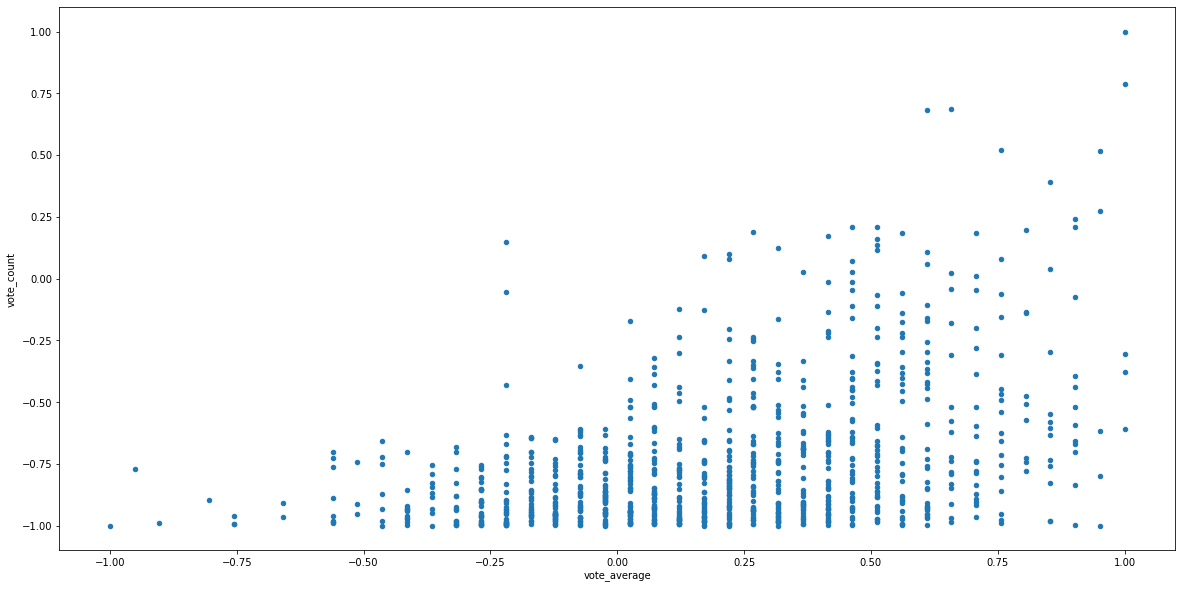

In [ ]:
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
data_scaled.plot.scatter("vote_average","vote_count",figsize=(20,10),ax=ax)
plt.show()

In [ ]:
benefice_ratio=(movies_db["revenue"]-movies_db["budget"])/movies_db["revenue"]
# print(benefice_ratio.describe())
benefice_ratio=pd.DataFrame(benefice_ratio)
scaler = MinMaxScaler((-1,1))
scaler.fit(benefice_ratio)
data_scaled["benefice_ratio"] = scaler.transform(benefice_ratio)
# ratio = 0.3*data_scaled["vote_average"]+0.5*(data_scaled['benefice_ratio'])+0.2*data_scaled["vote_count"]
ratio = (data_scaled["vote_average"]+data_scaled['benefice_ratio']+data_scaled["vote_count"])/3
ratio.describe()

count    938.000000
mean       0.150637
std        0.181085
min       -0.565024
25%        0.026361
50%        0.123820
75%        0.250334
max        0.999860
dtype: float64

In [ ]:
movies_db['ratio'] = ratio
movies_db.sort_values("ratio",ascending=False)

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer,year,ratio
203,27205,Inception,160000000,"'Action', 'Science Fiction', 'Adventure'",en,"Cobb, a skilled thief who commits corporate es...","'Legendary Pictures', 'Syncopy', 'Warner Bros....",2010-07-15,825532764,148.0,8.4,30898,"[Leonardo DiCaprio, Leonardo DiCaprio, Dom Cob...","{'adult': False, 'gender': 2, 'id': 525, 'know...","{'adult': False, 'gender': 2, 'id': 525, 'know...",156.821,18.254,27.309,2010,0.999860
190,157336,Interstellar,165000000,"'Adventure', 'Drama', 'Science Fiction'",en,The adventures of a group of explorers who mak...,"'Legendary Pictures', 'Syncopy', 'Lynda Obst P...",2014-11-05,701729206,169.0,8.4,27770,"[Matthew McConaughey, Matthew McConaughey, Jos...","{'adult': False, 'gender': 2, 'id': 525, 'know...","{'adult': False, 'gender': 2, 'id': 525, 'know...",106.888,18.254,28.069,2014,0.928409
269,299536,Avengers: Infinity War,300000000,"'Adventure', 'Action', 'Science Fiction'",en,As the Avengers and their allies have continue...,'Marvel Studios',2018-04-25,2046239637,149.0,8.3,23864,"[Robert Downey, Robert Downey, Tony Stark, Iro...","{'adult': False, 'gender': 2, 'id': 19271, 'kn...","{'adult': False, 'gender': 2, 'id': 10850, 'kn...",176.206,15.108,14.260,2018,0.823030
181,24428,The Avengers,220000000,"'Science Fiction', 'Action', 'Adventure'",en,When an unexpected enemy emerges and threatens...,'Marvel Studios',2012-04-25,1518815515,143.0,7.7,26313,"[Robert Downey, Robert Downey, Tony Stark, Iro...","{'adult': False, 'gender': 2, 'id': 12891, 'kn...","{'adult': False, 'gender': 2, 'id': 10850, 'kn...",176.206,8.873,12.818,2012,0.781388
229,293660,Deadpool,58000000,"'Action', 'Adventure', 'Comedy'",en,Deadpool tells the origin story of former Spec...,"'20th Century Fox', 'Marvel Entertainment', ""T...",2016-02-09,783100000,108.0,7.6,26250,"[Ryan Reynolds, Ryan Reynolds, Wade Wilson, Mo...","{'adult': False, 'gender': 2, 'id': 55252, 'kn...","{'adult': False, 'gender': 1, 'id': 7200, 'kno...",124.922,8.362,63.261,2016,0.763741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,241251,The Boy Next Door,4000000,'Thriller',en,A recently cheated on married woman falls for ...,"'Smart Entertainment', 'Blumhouse Productions'...",2015-01-23,52425855,91.0,4.8,1792,"[Jennifer Lopez, Jennifer Lopez, Claire Peters...","{'adult': False, 'gender': 2, 'id': 18878, 'kn...","{'adult': False, 'gender': 1, 'id': 16866, 'kn...",75.494,5.817,33.230,2015,-0.249985
550,329833,Zoolander 2,50000000,'Comedy',en,Derek and Hansel are modelling again when an o...,"'Scott Rudin Productions', 'Red Hour'",2016-02-06,55969000,100.0,4.8,1817,"[Ben Stiller, Ben Stiller, Derek Zoolander, Ow...","{'adult': False, 'gender': 2, 'id': 7399, 'kno...","{'adult': False, 'gender': 2, 'id': 2997, 'kno...",133.058,14.784,21.056,2016,-0.250020
726,87818,Movie 43,6000000,'Comedy',en,Fifteen directors and an all-star cast created...,"'Witness Protection Films', 'Relativity Media'...",2013-01-01,32438988,90.0,4.5,1858,"[Hugh Jackman, Hugh Jackman, Davis , segment ,...","{'adult': False, 'gender': 2, 'id': 2171, 'kno...","{'adult': False, 'gender': 2, 'id': 7396, 'kno...",115.447,70.390,7.857,2013,-0.297339
583,71880,Jack and Jill,79000000,'Comedy',en,"Jack Sadelstein, a successful advertising exec...","'Broken Road Productions', 'Columbia Pictures'...",2011-11-11,149673788,91.0,4.3,1701,"[Adam Sandler, Adam Sandler, Jack , Katie Holm...","{'adult': False, 'gender': 2, 'id': 17494, 'kn...","{'adult': False, 'gender': 2, 'id': 11814, 'kn...",101.717,5.360,30.769,2011,-0.333699


In [ ]:
def class_df(row):
  # SUPER HIT
  if row["ratio"] >= 0.5:
    return "SUPER HIT"
  # HIT
  elif 0.25<= row["ratio"] <.5 :
    return "HIT"
  # BOF
  elif 0<= row["ratio"] <0.25 :
    return "BOF"
  # FlOP
  else:
    return "FLOP"

movies_db["target"]=movies_db.apply(lambda row: class_df(row), axis=1)

In [ ]:
movies_db.sort_values("ratio",ascending=False)

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer,year,ratio,target
203,27205,Inception,160000000,"'Action', 'Science Fiction', 'Adventure'",en,"Cobb, a skilled thief who commits corporate es...","'Legendary Pictures', 'Syncopy', 'Warner Bros....",2010-07-15,825532764,148.0,8.4,30898,"[Leonardo DiCaprio, Leonardo DiCaprio, Dom Cob...","{'adult': False, 'gender': 2, 'id': 525, 'know...","{'adult': False, 'gender': 2, 'id': 525, 'know...",156.821,18.254,27.309,2010,0.999860,SUPER HIT
190,157336,Interstellar,165000000,"'Adventure', 'Drama', 'Science Fiction'",en,The adventures of a group of explorers who mak...,"'Legendary Pictures', 'Syncopy', 'Lynda Obst P...",2014-11-05,701729206,169.0,8.4,27770,"[Matthew McConaughey, Matthew McConaughey, Jos...","{'adult': False, 'gender': 2, 'id': 525, 'know...","{'adult': False, 'gender': 2, 'id': 525, 'know...",106.888,18.254,28.069,2014,0.928409,SUPER HIT
269,299536,Avengers: Infinity War,300000000,"'Adventure', 'Action', 'Science Fiction'",en,As the Avengers and their allies have continue...,'Marvel Studios',2018-04-25,2046239637,149.0,8.3,23864,"[Robert Downey, Robert Downey, Tony Stark, Iro...","{'adult': False, 'gender': 2, 'id': 19271, 'kn...","{'adult': False, 'gender': 2, 'id': 10850, 'kn...",176.206,15.108,14.260,2018,0.823030,SUPER HIT
181,24428,The Avengers,220000000,"'Science Fiction', 'Action', 'Adventure'",en,When an unexpected enemy emerges and threatens...,'Marvel Studios',2012-04-25,1518815515,143.0,7.7,26313,"[Robert Downey, Robert Downey, Tony Stark, Iro...","{'adult': False, 'gender': 2, 'id': 12891, 'kn...","{'adult': False, 'gender': 2, 'id': 10850, 'kn...",176.206,8.873,12.818,2012,0.781388,SUPER HIT
229,293660,Deadpool,58000000,"'Action', 'Adventure', 'Comedy'",en,Deadpool tells the origin story of former Spec...,"'20th Century Fox', 'Marvel Entertainment', ""T...",2016-02-09,783100000,108.0,7.6,26250,"[Ryan Reynolds, Ryan Reynolds, Wade Wilson, Mo...","{'adult': False, 'gender': 2, 'id': 55252, 'kn...","{'adult': False, 'gender': 1, 'id': 7200, 'kno...",124.922,8.362,63.261,2016,0.763741,SUPER HIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,241251,The Boy Next Door,4000000,'Thriller',en,A recently cheated on married woman falls for ...,"'Smart Entertainment', 'Blumhouse Productions'...",2015-01-23,52425855,91.0,4.8,1792,"[Jennifer Lopez, Jennifer Lopez, Claire Peters...","{'adult': False, 'gender': 2, 'id': 18878, 'kn...","{'adult': False, 'gender': 1, 'id': 16866, 'kn...",75.494,5.817,33.230,2015,-0.249985,FLOP
550,329833,Zoolander 2,50000000,'Comedy',en,Derek and Hansel are modelling again when an o...,"'Scott Rudin Productions', 'Red Hour'",2016-02-06,55969000,100.0,4.8,1817,"[Ben Stiller, Ben Stiller, Derek Zoolander, Ow...","{'adult': False, 'gender': 2, 'id': 7399, 'kno...","{'adult': False, 'gender': 2, 'id': 2997, 'kno...",133.058,14.784,21.056,2016,-0.250020,FLOP
726,87818,Movie 43,6000000,'Comedy',en,Fifteen directors and an all-star cast created...,"'Witness Protection Films', 'Relativity Media'...",2013-01-01,32438988,90.0,4.5,1858,"[Hugh Jackman, Hugh Jackman, Davis , segment ,...","{'adult': False, 'gender': 2, 'id': 2171, 'kno...","{'adult': False, 'gender': 2, 'id': 7396, 'kno...",115.447,70.390,7.857,2013,-0.297339,FLOP
583,71880,Jack and Jill,79000000,'Comedy',en,"Jack Sadelstein, a successful advertising exec...","'Broken Road Productions', 'Columbia Pictures'...",2011-11-11,149673788,91.0,4.3,1701,"[Adam Sandler, Adam Sandler, Jack , Katie Holm...","{'adult': False, 'gender': 2, 'id': 17494, 'kn...","{'adult': False, 'gender': 2, 'id': 11814, 'kn...",101.717,5.360,30.769,2011,-0.333699,FLOP


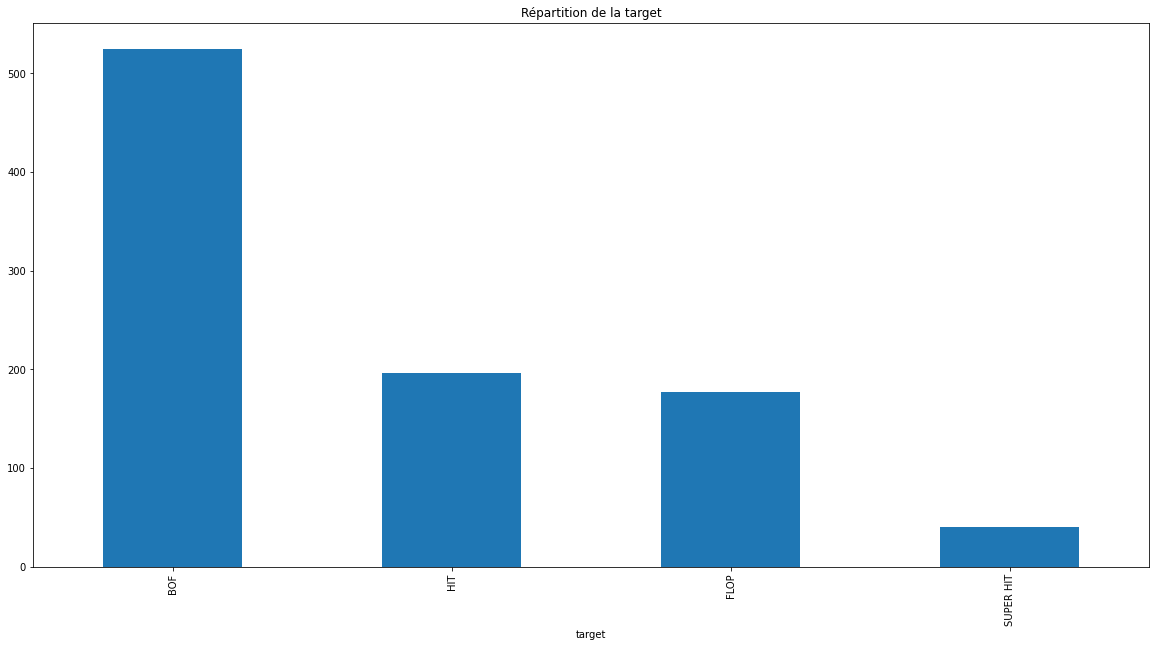

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.ticklabel_format(style='plain')
# movies_db.hist("target",bins=20,ax=ax)
movies_db['target'].value_counts().plot(kind='bar')
plt.title('Répartition de la target')
plt.xlabel('target')
plt.show()

In [ ]:
movies_db["target"].value_counts()

BOF          525
HIT          196
FLOP         177
SUPER HIT     40
Name: target, dtype: int64

1 9.392525379105699e+19
2 3.1841840466717385e+19
3 1.8246287144471552e+19
4 1.1709167249228132e+19
5 8.304485465982459e+18
6 6.150580058844278e+18
7 5.202294648239423e+18
8 4.2253901454965975e+18
9 3.72657844517867e+18
10 3.2261052341707776e+18


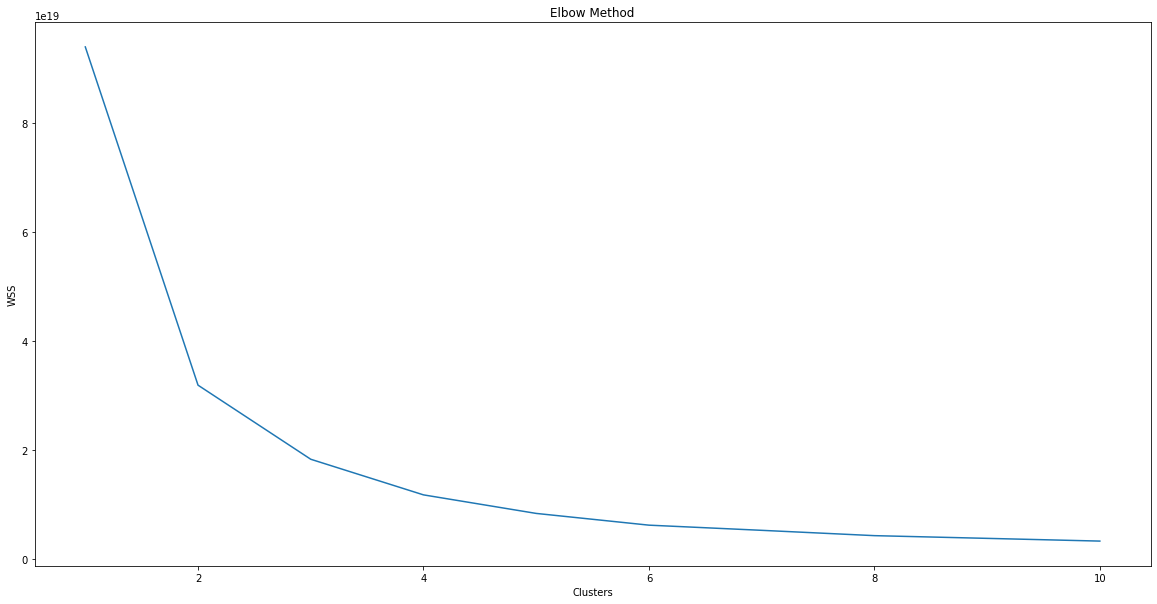

In [ ]:
from sklearn.cluster import KMeans
df=movies_db[["revenue","budget","vote_average",'vote_count']]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(df)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++',random_state = 0)
estimator = kmeans.fit(df)
estimator

KMeans(n_clusters=4, random_state=0)

In [ ]:
class_predict = estimator.predict(df)
movies_db["target2"] = class_predict

In [ ]:
pd.crosstab(movies_db["target"],movies_db['target2'])

target2,0,1,2,3
target,,,,
BOF,372,28,124,1
FLOP,137,0,40,0
HIT,80,44,60,12
SUPER HIT,5,21,8,6


In [ ]:

#df['class'] = np.where(df['ratio']>='Z', 'green', 'red')

# **Exploration des données**

In [ ]:
movies_db.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,budget,revenue,runtime,vote_average,vote_count,pop_actors,pop_directors,pop_producer,year,ratio,target2
count,938.0,938.0,938.0,938.0,938.0,938.0,938.0,938.0,938.0,938.0,938.0
mean,73259976.4,262629616.3,114.3,6.8,5469.5,97.5,7.4,14.3,2014.8,0.2,0.7
std,65434808.7,309771988.3,18.3,0.7,4241.9,31.9,7.4,15.1,3.0,0.2,0.9
min,100000.0,107423.0,80.0,4.3,1700.0,16.1,0.6,0.0,2010.0,-0.6,0.0
25%,24000000.0,66845114.0,101.0,6.3,2544.8,76.1,2.7,3.7,2012.0,0.0,0.0
50%,50000000.0,154011977.5,112.0,6.8,4007.0,93.0,5.5,9.2,2015.0,0.1,0.0
75%,110000000.0,332145029.5,125.0,7.3,6673.0,115.3,9.5,19.0,2017.0,0.3,2.0
max,380000000.0,2797800564.0,242.0,8.4,30898.0,289.7,83.0,106.9,2021.0,1.0,3.0


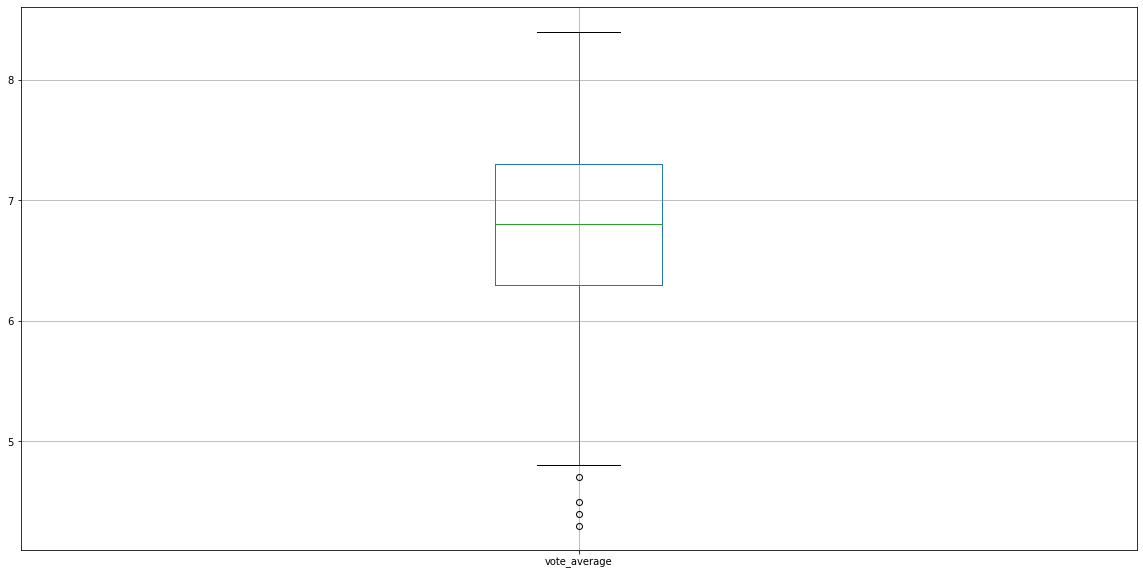

In [ ]:
movies_db[["vote_average"]].boxplot(figsize=(20,10))

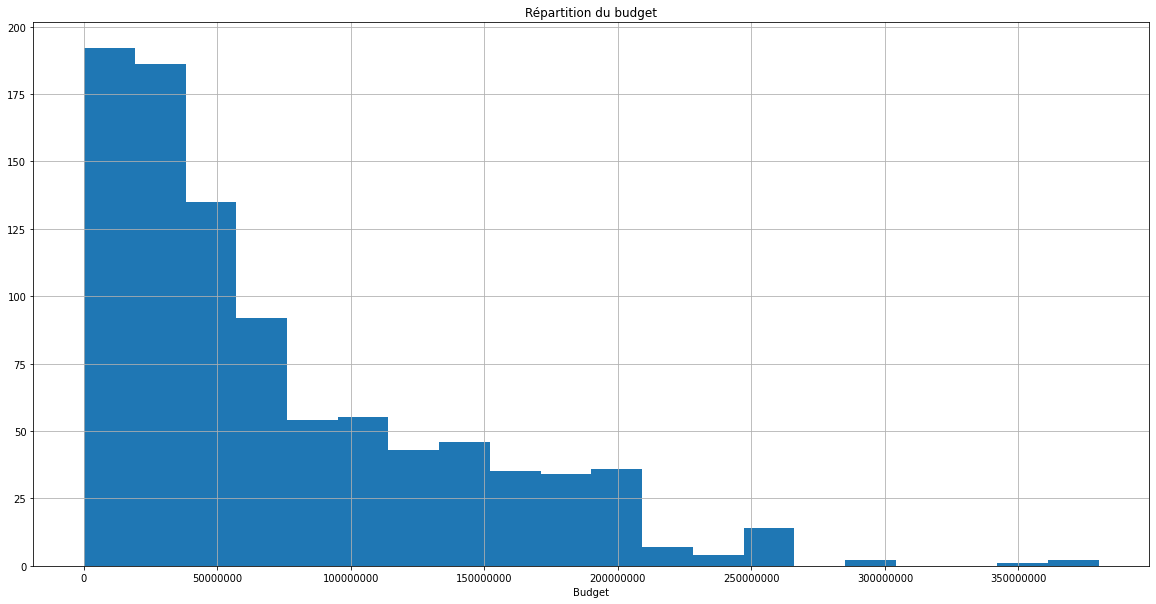

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.ticklabel_format(style='plain')
movies_db.hist("budget",bins=20,ax=ax)
plt.title('Répartition du budget')
plt.xlabel('Budget')
plt.show()

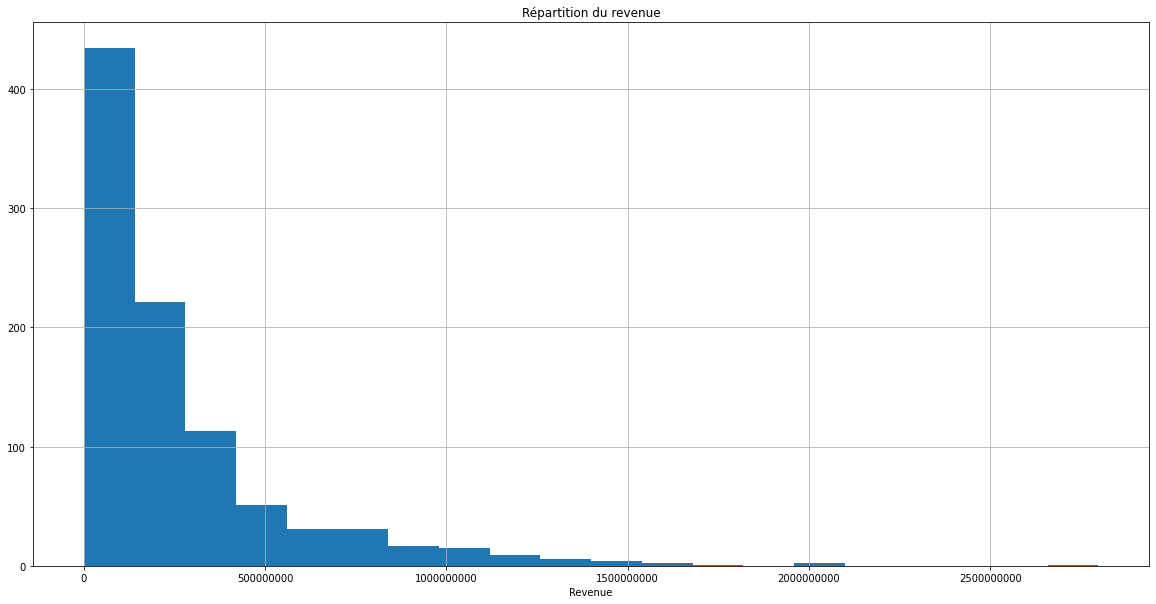

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.ticklabel_format(style='plain')
movies_db.hist("revenue",bins=20,ax=ax)
plt.title('Répartition du revenue')
plt.xlabel('Revenue')
plt.show()

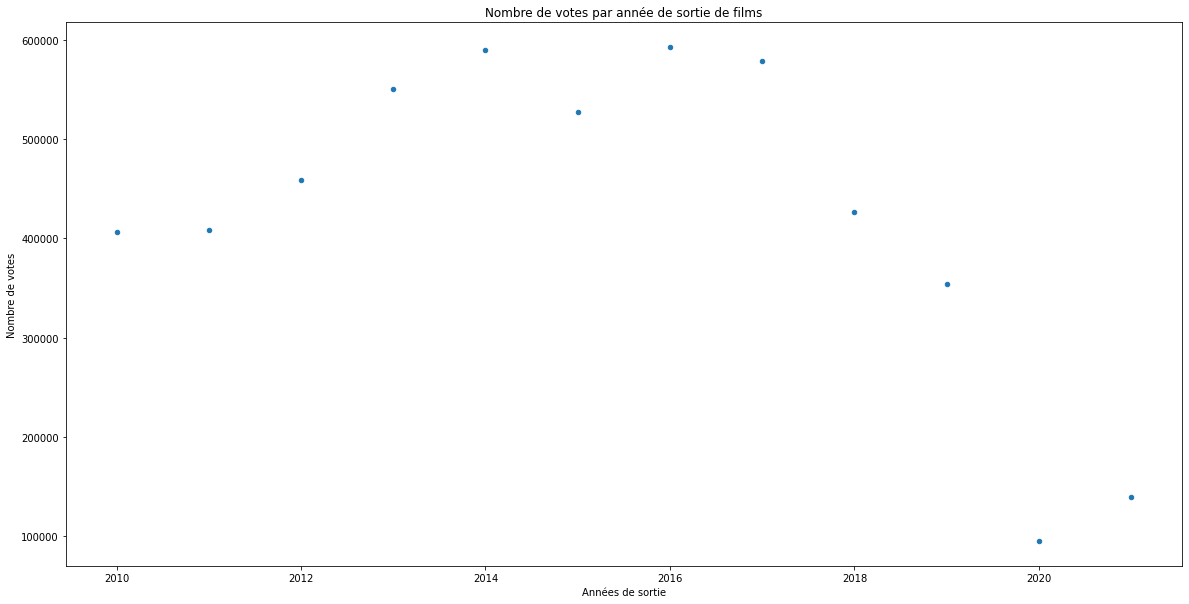

In [ ]:
movies_db.pivot_table(values="vote_count",index="year",aggfunc="sum").reset_index().plot.scatter('year','vote_count',figsize=(20,10))
plt.title("Nombre de votes par année de sortie de films")
plt.xlabel("Années de sortie")
plt.ylabel("Nombre de votes")
plt.show()

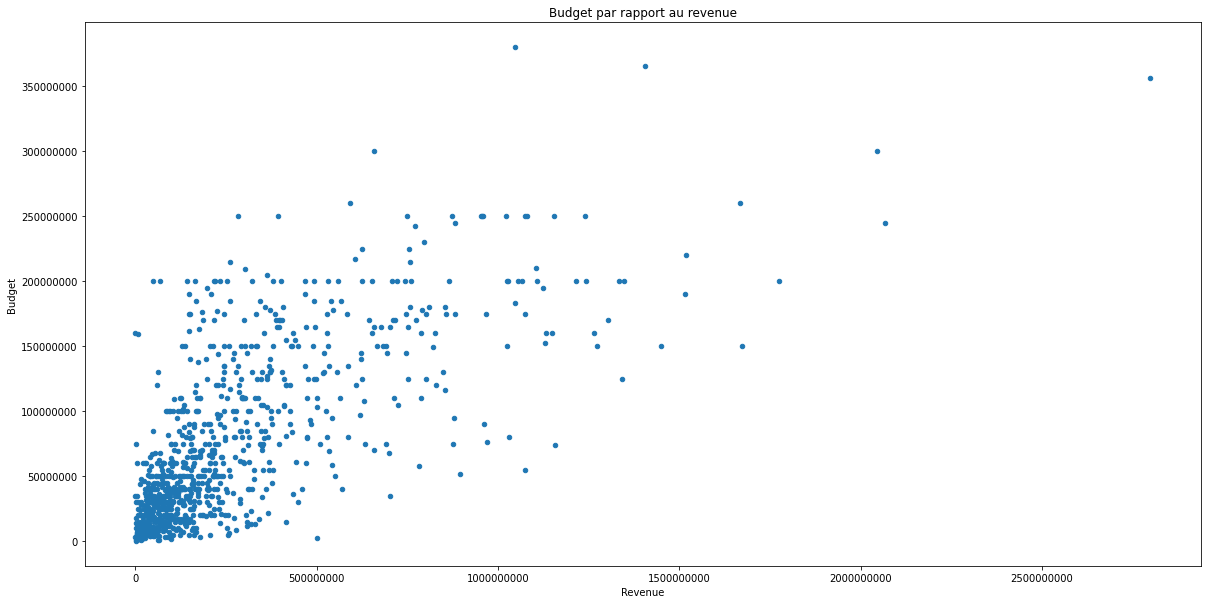

In [ ]:
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
movies_db.plot.scatter("revenue","budget",figsize=(20,10),ax=ax)
plt.title("Budget par rapport au revenue")
plt.xlabel("Revenue")
plt.ylabel("Budget")
plt.show()

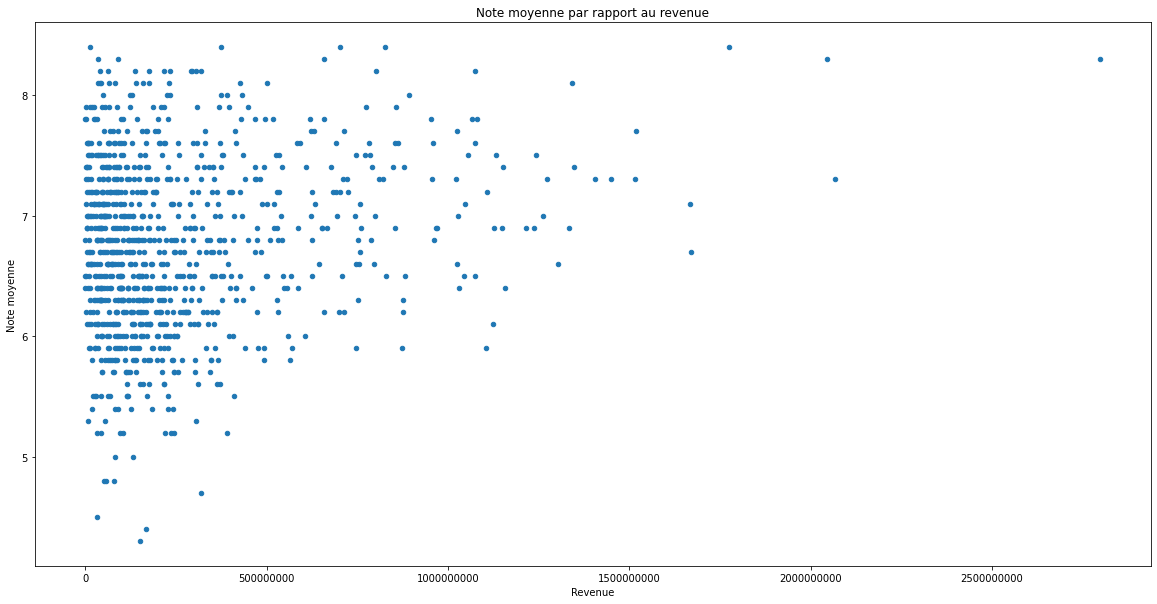

In [ ]:
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
movies_db.plot.scatter("revenue","vote_average",figsize=(20,10),ax=ax)
plt.title("Note moyenne par rapport au revenue")
plt.xlabel("Revenue")
plt.ylabel("Note moyenne")
plt.show()

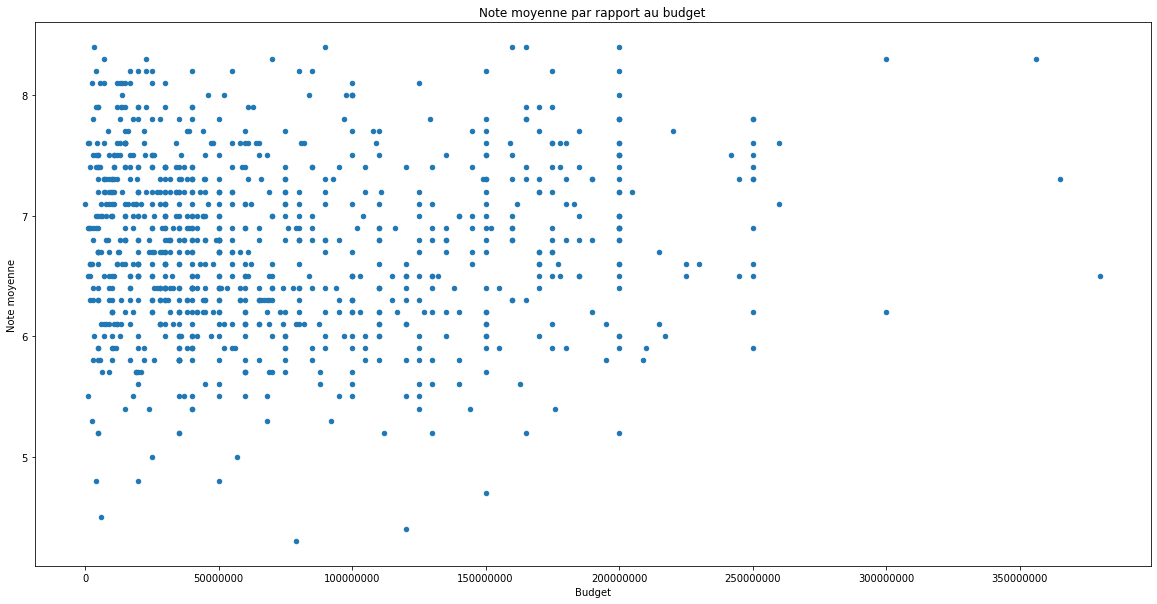

In [ ]:
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain')
movies_db.plot.scatter("budget","vote_average",figsize=(20,10),ax=ax)
plt.title("Note moyenne par rapport au budget")
plt.xlabel("Budget")
plt.ylabel("Note moyenne")
plt.show()

## *Exploration par genres, compagnies de production,réalisateurs, producteurs*

In [ ]:
movies_db['genres'] = movies_db['genres'].str.split(',')
movies_db['production_companies'] = movies_db['production_companies'].str.split(',')
movies_db["genres"] = movies_db["genres"].apply(lambda s: [x.strip().replace("'","") for x in s])
movies_db["production_companies"] = movies_db["production_companies"].apply(lambda s: [x.strip().replace("'","") for x in s])

In [ ]:
"""
companies_explode = movies_db.explode('production_companies')
companies_pivot = pd.pivot_table(companies_explode,values='revenue',index='production_companies',aggfunc=['count','min','max','mean','sum'])
tri_companies = companies_pivot['sum'].sort_values(ascending=False,by='revenue').reset_index()['production_companies']
companies_pivot.loc[tri_companies].apply(lambda s: s.apply('{0:.1f}'.format))
"""

companies_explode = movies_db.explode('production_companies')
companies_pivot = pd.pivot_table(companies_explode,values='ratio',index='production_companies',aggfunc='mean')
companies_pivot.sort_values(by="ratio", ascending=False)

,ratio
production_companies,
Lynda Obst Productions,0.928409
Phoenix Pictures,0.703588
Paramount Home Entertainment,0.667335
EMJAG Productions,0.667335
Kennedy Miller Productions,0.581272
...,...
GreeneStreet Films,-0.297339
Witness Protection Films,-0.297339
Wessler Entertainment,-0.297339


In [ ]:
"""
actors_explode = movies_db.explode('actors')
actors_pivot = pd.pivot_table(actors_explode,values='revenue',index='actors',aggfunc=['count','min','max','mean','sum'])
tri_actors = actors_pivot['sum'].sort_values(ascending=False,by='revenue').reset_index()['actors']
actors_pivot.loc[tri_actors].apply(lambda s: s.apply('{0:.1f}'.format)) 

actors_explode = movies_db.explode('actors')
actors_pivot = pd.pivot_table(actors_explode,values='ratio',index='actors',aggfunc='mean')
actors_pivot.sort_values(by="ratio", ascending=False)
"""

'\nactors_explode = movies_db.explode(\'actors\')\nactors_pivot = pd.pivot_table(actors_explode,values=\'revenue\',index=\'actors\',aggfunc=[\'count\',\'min\',\'max\',\'mean\',\'sum\'])\ntri_actors = actors_pivot[\'sum\'].sort_values(ascending=False,by=\'revenue\').reset_index()[\'actors\']\nactors_pivot.loc[tri_actors].apply(lambda s: s.apply(\'{0:.1f}\'.format)) \n\nactors_explode = movies_db.explode(\'actors\')\nactors_pivot = pd.pivot_table(actors_explode,values=\'ratio\',index=\'actors\',aggfunc=\'mean\')\nactors_pivot.sort_values(by="ratio", ascending=False)\n'

In [ ]:
#pd.pivot_table(actors_explode,index='actors').reset_index()[['actors']].to_csv("actors.csv",index=False)

In [ ]:
movies_db['science_fiction'] = movies_db["genres"].apply(lambda s: 1 if "Science Fiction" in s else 0)
movies_db['adventure'] = movies_db["genres"].apply(lambda s: 1 if "Adventure" in s else 0)
movies_db['drama'] = movies_db["genres"].apply(lambda s: 1 if "Drama" in s else 0)
movies_db['comedy'] = movies_db["genres"].apply(lambda s: 1 if "Comedy" in s else 0)
movies_db['action'] = movies_db["genres"].apply(lambda s: 1 if "Action" in s else 0)
movies_db['fantasy'] = movies_db["genres"].apply(lambda s: 1 if "Fantasy" in s else 0)
movies_db['thriller'] = movies_db["genres"].apply(lambda s: 1 if "Thriller" in s else 0)
movies_db['animation'] = movies_db["genres"].apply(lambda s: 1 if "Animation" in s else 0)
movies_db['family'] = movies_db["genres"].apply(lambda s: 1 if "Family" in s else 0)

In [ ]:
"""
movies_db['pop_company'] = movies_db["production_companies"].apply(lambda s: max(companies_pivot.loc[s]["ratio"]))
movies_db['pop_director'] = movies_db["director"].apply(lambda s: max(director_pivot.loc[s]["ratio"]))
movies_db['pop_producers'] = movies_db["producers"].apply(lambda s: max(producers_pivot.loc[s]["ratio"]))
movies_db['pop_actors'] = movies_db["actors"].apply(lambda s: sum(actors_pivot.loc[s]["ratio"]))
"""

'\nmovies_db[\'pop_company\'] = movies_db["production_companies"].apply(lambda s: max(companies_pivot.loc[s]["ratio"]))\nmovies_db[\'pop_director\'] = movies_db["director"].apply(lambda s: max(director_pivot.loc[s]["ratio"]))\nmovies_db[\'pop_producers\'] = movies_db["producers"].apply(lambda s: max(producers_pivot.loc[s]["ratio"]))\nmovies_db[\'pop_actors\'] = movies_db["actors"].apply(lambda s: sum(actors_pivot.loc[s]["ratio"]))\n'

In [ ]:
movies_db

,id,title,budget,genres,original_language,overview,production_companies,release_date,revenue,runtime,vote_average,vote_count,actors,director,producers,pop_actors,pop_directors,pop_producer,year,ratio,target,target2,science_fiction,adventure,drama,comedy,action,fantasy,thriller,animation,family
0,524434,Eternals,200000000,"[Action, Adventure, Fantasy, Science Fiction]",en,The Eternals are a team of ancient aliens who ...,[Marvel Studios],2021-11-03,402027582,156.0,7.2,4137,"[Gemma Chan, Gemma Chan, Richard Madden, Richa...","{'adult': False, 'gender': 1, 'id': 1395183, '...","{'adult': False, 'gender': 2, 'id': 10850, 'kn...",125.108,11.639,14.992,2021,0.193489,BOF,2,1,1,0,0,1,1,0,0,0
1,189,Sin City: A Dame to Kill For,65000000,"[Crime, Action, Thriller]",en,Some of Sin City's most hard-boiled citizens c...,"[Residaco, Miramax, Troublemaker Studios, Alda...",2014-08-20,39407616,102.0,6.3,3118,"[Mickey Rourke, Mickey Rourke, Jessica Alba, J...","{'adult': False, 'gender': 2, 'id': 2294, 'kno...","{'adult': False, 'gender': 2, 'id': 2294, 'kno...",122.319,14.280,12.013,2014,0.023026,BOF,0,0,0,0,0,1,0,1,0,0
2,393457,Fences,24000000,[Drama],en,"In 1950s Pittsburgh, a frustrated African-Amer...","[Paramount, Scott Rudin Productions, MACRO, Br...",2016-12-16,64414761,139.0,6.8,2115,"[Denzel Washington, Denzel Washington, Troy Ma...","{'adult': False, 'gender': 2, 'id': 5292, 'kno...","{'adult': False, 'gender': 2, 'id': 2997, 'kno...",73.304,32.818,35.038,2016,0.082373,BOF,0,0,0,1,0,0,0,0,0,0
3,262500,Insurgent,110000000,"[Action, Adventure, Science Fiction, Thriller]",en,Beatrice Prior must confront her inner demons ...,"[Summit Entertainment, Red Wagon Entertainment...",2015-03-18,295238201,119.0,6.4,8735,"[Shailene Woodley, Shailene Woodley, Beatrice ...","{'adult': False, 'gender': 2, 'id': 57270, 'kn...","{'adult': False, 'gender': 2, 'id': 931, 'know...",93.900,2.412,3.066,2015,0.168485,BOF,2,1,1,0,0,1,0,1,0,0
4,262504,Allegiant,110000000,"[Adventure, Science Fiction, Action, Mystery]",en,Beatrice Prior and Tobias Eaton venture into t...,"[Mandeville Films, Summit Entertainment, Lions...",2016-03-09,179246868,120.0,6.1,5658,"[Shailene Woodley, Shailene Woodley, Beatrice ...","{'adult': False, 'gender': 2, 'id': 57270, 'kn...","{'adult': False, 'gender': 2, 'id': 931, 'know...",91.913,2.412,3.066,2016,0.049269,BOF,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,522938,Rambo: Last Blood,50000000,"[Action, Thriller, Drama]",en,"After fighting his demons for decades, John Ra...","[Millennium Films, Templeton Media, Campbell G...",2019-09-19,91490353,89.0,6.5,2925,"[Sylvester Stallone, Sylvester Stallone, John ...","{'adult': False, 'gender': 2, 'id': 589402, 'k...","{'adult': False, 'gender': 0, 'id': 16486, 'kn...",79.491,4.049,6.938,2019,0.051958,BOF,0,0,0,1,0,1,0,1,0,0
934,392044,Murder on the Orient Express,55000000,"[Mystery, Crime, Drama]",en,Genius Belgian detective Hercule Poirot invest...,"[The Mark Gordon Company, Scott Free Productio...",2017-11-03,351839303,114.0,6.7,8045,"[Tom Bateman, Tom Bateman, Kenneth Branagh, Ke...","{'adult': False, 'gender': 2, 'id': 11181, 'kn...","{'adult': False, 'gender': 2, 'id': 578, 'know...",143.077,20.555,47.196,2017,0.201671,BOF,2,0,0,1,0,0,0,0,0,0
935,261023,Black Mass,53000000,"[Drama, Crime, History]",en,"The true story of Whitey Bulger, the brother o...","[Vendian Entertainment, Infinitum Nihil, Head ...",2015-09-04,98837872,123.0,6.4,2787,"[Johnny Depp, Johnny Depp, James , Joel Edgert...","{'adult': False, 'gender': 2, 'id': 65167, 'kn...","{'adult': False, 'gender': 2, 'id': 57049, 'kn...",91.819,5.977,11.275,2015,0.032555,BOF,0,0,0,1,0,0,0,0,0,0
936,261392,American Ultra,28000000,"[Comedy, Action]",en,Mike is an unmotivated stoner whose small-town...,"[Merced Media Partners, Lionsgate, The Bridge ...",2015-08-19,27139524,96.0,6.1,2368,"[Jesse Eisenberg, Jesse Eisenberg, Mike

In [ ]:
# movies_db[["title"]].to_csv("movies_titles.csv")

IMPORT YOUTUBE LIKE VIEWS AND INSTAGRAM FOLLOWERS 

In [ ]:
youtube = pd.read_csv("Film_View_Like_BIS.csv",engine='python',names=["count_view","count_like"],sep=None)

In [ ]:
youtube

In [ ]:
youtube.reset_index(inplace=True)

In [ ]:
youtube.rename(columns={"index":"title"},inplace=True)

In [ ]:
# instagram = pd.read_csv("actors_nb_ab.csv",engine='python',names=["actors","followers"],sep=None)
# instagram

In [ ]:
# instagram.set_index("actors",inplace=True)

In [ ]:
# instagram.loc["Aaron Paul"]

In [ ]:
# followers=[]
# for i in range(len(movies_db["actors"])):
#   sum=0
#   for actor in movies_db["actors"][i]:
#     if actor in instagram.index.values:
#       sum+=instagram.loc[actor]["followers"]
#   followers.append(sum)

In [ ]:
# movies_db['pop_actors'] = 
# movies_db["actors_followers"]=followers

In [ ]:
youtube.head()

Had an issue with Robin hood, there are 2 movies with the same name

In [ ]:
# movies_db.loc[143,"title"]="Robin Hood 2010"
# movies_db.loc[838,"title"]="Robin Hood 2018"

In [ ]:
# movies_db[(movies_db["title"]=='Robin Hood 2010')]

In [ ]:
youtube

In [ ]:
movies_db['title']=movies_db['title'].apply(lambda s: s.replace(":"," "))
movies_db['title']=movies_db['title'].apply(lambda s: s.replace("-"," "))
youtube['title']=youtube['title'].apply(lambda s: s.replace('"',''))
youtube['title']=youtube['title'].apply(lambda s: s.replace(":"," "))
youtube['title']=youtube['title'].apply(lambda s: s.replace("-"," "))

In [ ]:
movies_db.merge(youtube, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']["title"]

In [ ]:
youtube.merge(movies_db, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']["title"]

In [ ]:
movies_db=pd.merge(movies_db,youtube,on=["title"])

In [ ]:
movies_db[movies_db.isnull().any(axis=1)]

In [ ]:
movies_model_data=movies_db.copy()

In [ ]:
movies_model_data.columns

In [ ]:
# movies_model_data.drop(["id","genres",'original_language', 'overview','production_companies', 'release_date','actors', 'director', 'producers','target2','year','vote_average','vote_count','revenue','ratio'],axis=1,inplace=True)
kmeans_movies=movies_db[["title",'vote_average','vote_count','revenue']]

In [ ]:
# movies_model_data

In [ ]:
# movies_model_data.to_csv("movies_model_data_final.csv",index=False)

In [ ]:
# movies_model_data = pd.read_csv("movies_model_data_final.csv",engine='python')

TEST SET AND TRAIN SET

In [ ]:
"""
x = movies_model_data.drop(["target2","title"],axis=1)
y = movies_model_data["target2"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
"""

In [ ]:
scaler = StandardScaler()
scaler.fit(movies_model_data.drop(["target","title"],axis=1))
movies_model_data_scaled = scaler.transform(movies_model_data.drop(["target","title"],axis=1))
movies_model_data_scaled = pd.DataFrame(movies_model_data_scaled)
movies_model_data_scaled.columns = movies_model_data.drop(["target","title"],axis=1).columns
movies_model_data_scaled["target"] = movies_model_data["target"]
movies_model_data_scaled["title"] = movies_model_data["title"]
movies_model_data_scaled

KMEANS


In [ ]:
kmeans_movies

In [ ]:
scaler = StandardScaler()
scaler.fit(kmeans_movies.drop(["title"],axis=1))
kmeans_movies_scaled = scaler.transform(kmeans_movies.drop(["title"],axis=1))
kmeans_movies_scaled = pd.DataFrame(kmeans_movies_scaled)
kmeans_movies_scaled.columns = kmeans_movies.drop(["title"],axis=1).columns
kmeans_movies_scaled["title"] = kmeans_movies["title"]
kmeans_movies_scaled

,vote_average,vote_count,revenue,title
0,0.624532,-0.314292,0.450242,Eternals
1,-0.641327,-0.554645,-0.720985,Sin City: A Dame to Kill For
2,0.061928,-0.791224,-0.640215,Fences
3,-0.500676,0.770245,0.105323,Insurgent
4,-0.922629,0.044468,-0.269318,Allegiant
...,...,...,...,...
933,-0.360025,-0.600169,-0.552763,Rambo: Last Blood
934,-0.078723,0.607494,0.288139,Murder on the Orient Express
935,-0.500676,-0.632719,-0.529031,Black Mass
936,-0.922629,-0.731549,-0.760610,American Ultra


1 2813.999999999999
2 1608.9620882221934
3 1104.592277078806
4 918.0981136300992
5 796.3217129342815
6 697.6087224299433
7 613.117094628841
8 553.0634773146824
9 508.62297784736126
10 470.4547479669893


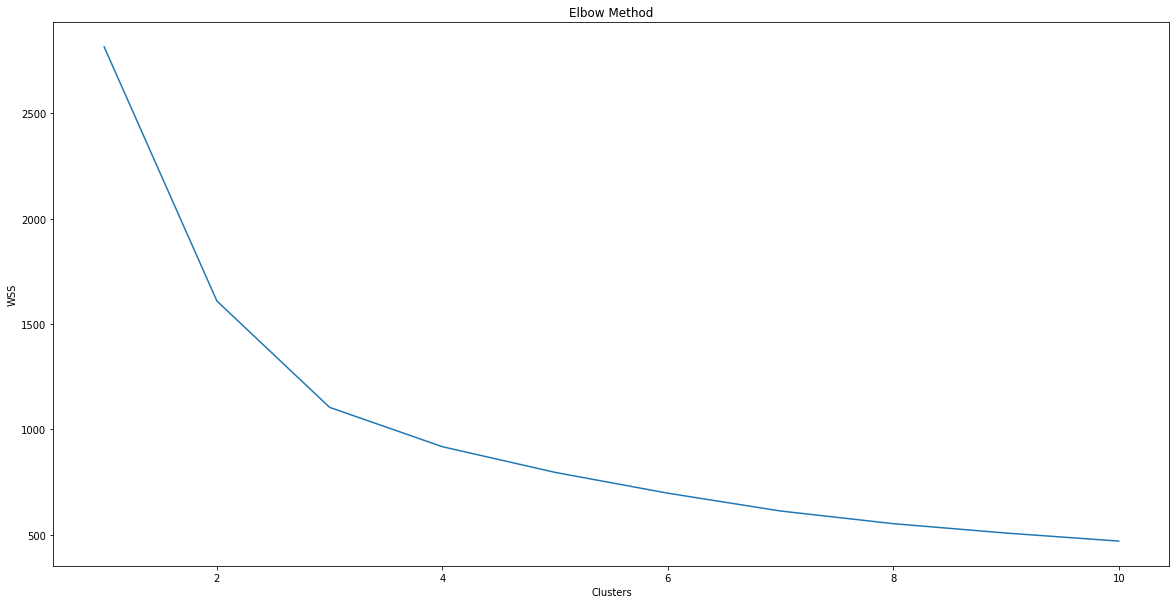

In [ ]:
from sklearn.cluster import KMeans
df_kmean=kmeans_movies_scaled[["revenue","vote_average",'vote_count']]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(df_kmean)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++',random_state = 0)
estimator = kmeans.fit(df_kmean)
estimator

KMeans(n_clusters=3, random_state=0)

In [ ]:
class_predict = estimator.predict(df_kmean)
df_kmean["target"] = class_predict
kmeans_movies_scaled["target"] = class_predict
movies_model_data_scaled["target"]=class_predict

In [ ]:
df_kmean["target"].value_counts()

0    400
1    310
2    228
Name: target, dtype: int64

In [ ]:
movies_model_data_scaled

,budget,runtime,pop_actors,pop_directors,pop_producer,science_fiction,adventure,drama,comedy,action,fantasy,thriller,animation,family,count_view,count_like,target,title
0,1.937923,2.271716,0.866281,0.579613,0.046925,1.971146,1.472725,-0.778566,-0.663973,1.275716,2.148666,-0.625853,-0.325779,-0.388485,1.539653,2.677256,1,Eternals
1,-0.126299,-0.673584,0.778697,0.936915,-0.151062,-0.507319,-0.679013,-0.778566,-0.663973,1.275716,-0.465405,1.597820,-0.325779,-0.388485,-0.482909,-0.336195,0,Sin City A Dame to Kill For
2,-0.753212,1.344492,-0.760544,3.444926,1.379200,-0.507319,-0.679013,1.284413,-0.663973,-0.783874,-0.465405,-0.625853,-0.325779,-0.388485,-0.505888,-0.325302,1,Fences
3,0.561775,0.253641,-0.113758,-0.668710,-0.745687,1.971146,1.472725,-0.778566,-0.663973,1.275716,-0.465405,1.597820,-0.325779,-0.388485,-0.108705,-0.187205,0,Insurgent
4,0.561775,0.308183,-0.176157,-0.668710,-0.745687,1.971146,1.472725,-0.778566,-0.663973,1.275716,-0.465405,-0.625853,-0.325779,-0.388485,-0.531555,-0.337457,0,Allegiant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,-0.355658,-1.382637,-0.566250,-0.447240,-0.488351,-0.507319,-0.679013,1.284413,-0.663973,1.275716,-0.465405,1.597820,-0.325779,-0.388485,-0.012452,0.110242,0,Rambo Last Blood
934,-0.279205,-0.019072,1.430570,1.785861,2.187232,-0.507319,-0.679013,1.284413,-0.663973,-0.783874,-0.465405,-0.625853,-0.325779,-0.388485,-0.004840,-0.082135,2,Murder on the Orient Express
935,-0.309786,0.471811,-0.179109,-0.186400,-0.200110,-0.507319,-0.679013,1.284413,-0.663973,-0.783874,-0.465405,-0.625853,-0.325779,-0.388485,-0.121625,-0.246589,0,Black Mass
936,-0.692049,-1.000839,-0.355031,-0.585236,-0.568901,-0.507319,-0.679013,-0.778566,1.506085,1.275716,-0.465405,-0.625853,-0.325779,-0.388485,-0.473398,-0.289494,0,American Ultra


In [ ]:
data_0 = movies_model_data_scaled[movies_model_data_scaled["target"] == 0]
data_1 = movies_model_data_scaled[movies_model_data_scaled["target"] == 1]
data_2 = movies_model_data_scaled[movies_model_data_scaled["target"] == 2]
# data_3 = movies_model_data_scaled[movies_model_data_scaled["target"] == "SUPER HIT"]

x_0 = data_0.drop(["target","title"],axis=1)
x_1 = data_1.drop(["target","title"],axis=1)
x_2 = data_2.drop(["target","title"],axis=1)
# x_3 = data_3.drop(["target","title"],axis=1)

y_0 = data_0["target"]
y_1 = data_1["target"]
y_2 = data_2["target"]
# y_3 = data_3["target"]

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_0, y_0, test_size=0.33)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.33)
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2, y_2, test_size=0.33)
# x_3_train, x_3_test, y_3_train, y_3_test = train_test_split(x_3, y_3, test_size=0.33)

x_train = pd.concat([x_0_train,x_1_train,x_2_train])
x_test = pd.concat([x_0_test,x_1_test,x_2_test])
y_train = pd.concat([y_0_train,y_1_train,y_2_train])
y_test = pd.concat([y_0_test,y_1_test,y_2_test])

"""
x_train = x_train.drop(["pop_company", "pop_actors", "pop_producers"],axis=1)
x_test = x_test.drop(["pop_company", "pop_actors", "pop_producers"],axis=1)
"""


'\nx_train = x_train.drop(["pop_company", "pop_actors", "pop_producers"],axis=1)\nx_test = x_test.drop(["pop_company", "pop_actors", "pop_producers"],axis=1)\n'

In [ ]:
x_train, x_test

(       budget   runtime  pop_actors  ...    family  count_view  count_like
 353 -0.661468  0.471811   -0.704646  ... -0.388485    0.443924   -0.090925
 829  1.479207 -0.073615    1.214703  ...  2.574105   -0.175758   -0.160164
 167 -0.508563 -1.055382   -0.137625  ... -0.388485   -0.778088   -0.402488
 3    0.561775  0.253641   -0.113758  ... -0.388485   -0.108705   -0.187205
 468  1.708565  0.417268   -0.241413  ... -0.388485   -0.548899   -0.313867
 ..        ...       ...         ...  ...       ...         ...         ...
 453 -0.860245 -0.237243   -0.092184  ... -0.388485    0.851346    0.198241
 190 -1.077371 -1.273552   -1.078692  ... -0.388485   -0.238138   -0.134050
 278 -0.997860 -1.164467   -0.734133  ... -0.388485   -0.233299   -0.287220
 690  1.402754 -0.728126   -1.183014  ...  2.574105   -0.187474   -0.299519
 826 -0.967279 -0.564498   -0.166108  ... -0.388485   -0.349275   -0.146460
 
 [627 rows x 16 columns],
        budget   runtime  pop_actors  ...    family  count_v

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(x_train,y_train)

y_pred_knn = knn.predict(x_test)
precision_score(y_test, y_pred_knn, average='micro')

0.43086816720257237

LDA

In [ ]:
lda = LDA()

lda.fit(x_train,y_train)

y_pred_lda = lda.predict(x_test)
precision_score(y_test, y_pred_lda, average='micro')

0.44694533762057875

QDA

In [ ]:
qda = QDA()

qda.fit(x_train,y_train)

y_pred_qda = qda.predict(x_test)
precision_score(y_test, y_pred_qda, average='micro')

0.42443729903536975

Naive Bayes

In [ ]:
nb = GaussianNB()

nb.fit(x_train,y_train)

y_pred_nb = nb.predict(x_test)
precision_score(y_test, y_pred_nb, average='micro')

0.45980707395498394

SVC

In [ ]:
svc = SVC()

svc.fit(x_train,y_train)

y_pred_svc = svc.predict(x_test)
precision_score(y_test, y_pred_svc, average='micro')

0.4405144694533762

RANDOM FOREST

In [ ]:
rfc = RandomForestClassifier()

rfc.fit(x_train,y_train)

y_pred_rfc = rfc.predict(x_test)
precision_score(y_test, y_pred_rfc, average='micro')

0.42443729903536975

XGBOOST

In [ ]:
XgBoost = xgb.XGBClassifier()
XgBoost.fit(x_train, y_train)
y_pred_xgb = XgBoost.predict(x_test)
precision_score(y_test, y_pred_xgb, average='micro')

0.4180064308681672

GRADIENT BOOSTING

In [ ]:
GradientBoost = GradientBoostingClassifier()
GradientBoost.fit(x_train, y_train)
y_pred_gb = GradientBoost.predict(x_test)
precision_score(y_test, y_pred_gb, average='micro')

0.3729903536977492

ADABOOST

In [ ]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(x_train, y_train)
y_pred_ab = AdaBoost.predict(x_test)
precision_score(y_test, y_pred_ab, average='micro')

0.40192926045016075

PCA

In [ ]:
pca = PCA(n_components = 'mle')
data_pca = movies_model_data.drop(["target","title"],axis=1)

scaler_pca = StandardScaler()
scaler_pca.fit(data_pca) 
data_pca = scaler_pca.transform(data_pca)
data_pca = pd.DataFrame(data_pca)
data_pca.columns = movies_model_data.drop(["target","title"],axis=1).columns

pca.fit(data_pca)

PCA(n_components='mle')

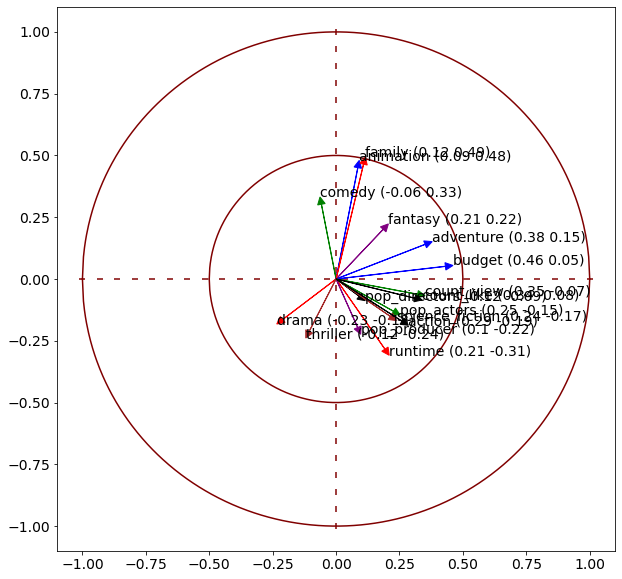

In [ ]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})

#Plot circle
#Create a list of 500 points with equal spacing between -1 and 1
x=np.linspace(start=-1,stop=1,num=500)
#Find y1 and y2 for these points
y_positive=lambda x: np.sqrt(1-x**2) 
y_negative=lambda x: -np.sqrt(1-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')

#Plot smaller circle
x=np.linspace(start=-0.5,stop=0.5,num=500)
y_positive=lambda x: np.sqrt(0.5**2-x**2) 
y_negative=lambda x: -np.sqrt(0.5**2-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')

#Create broken lines
x=np.linspace(start=-1,stop=1,num=30)
plt.scatter(x,[0]*len(x), marker='_',color='maroon')
plt.scatter([0]*len(x), x, marker='|',color='maroon')

#Define color list
colors = ['blue', 'red', 'green', 'black', 'purple', 'brown']
if len(pca.components_[0]) > 6:
    colors=colors*(int(len(pca.components_[0])/6)+1)

add_string=""
for i in range(len(pca.components_[0])):
    xi=pca.components_[0][i]
    yi=pca.components_[1][i]
    plt.arrow(0,0, 
              dx=xi, dy=yi, 
              head_width=0.03, head_length=0.03, 
              color=colors[i], length_includes_head=True)
    add_string=f" ({round(xi,2)} {round(yi,2)})"
    plt.text(pca.components_[0, i], 
             pca.components_[1, i] , 
             s=data_pca.columns[i] + add_string )

In [ ]:
x_train_df = pd.DataFrame(x_train)
x_train_df.columns = movies_model_data.drop(["target","title"],axis=1).columns

x_test_df = pd.DataFrame(x_test)
x_test_df.columns = movies_model_data.drop(["target","title"],axis=1).columns

y_train_df = pd.DataFrame(y_train)
y_train_df.columns = ["target"]

y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ["target"]

In [ ]:
"""
x_train_df.to_csv("x_train_df.csv", sep=";", index=False)
x_test_df.to_csv("x_test_df.csv", sep=";", index=False)
y_train_df.to_csv("y_train_df.csv", sep=";", index=False)
y_test_df.to_csv("y_test_df.csv", sep=";", index=False)
"""

## LDA From Scratch

Subset the training set into two sets: class0 where Purchased = 0 and class1 where Purchased = 1)

In [ ]:
x_0_train, x_1_train, x_2_train, x_3_train

NameError: ignored

Compute  π0  and π1

In [ ]:
pi0 = len(x_0_train) / len(x_train)
pi1 = len(x_1_train) / len(x_train)
pi2 = len(x_2_train) / len(x_train)
pi3 = len(x_3_train) / len(x_train)

In [ ]:
pi0, pi1, pi2, pi3

Compute  μ0 and  μ1

In [ ]:
np.mean(x_0_train, axis=0)

In [ ]:
mu0 = np.mean(x_0_train, axis=0)
mu1 = np.mean(x_1_train, axis=0)
mu2 = np.mean(x_2_train, axis=0)
mu3 = np.mean(x_3_train, axis=0)

In [ ]:
mu0, mu1, mu2, mu3

Compute Σ

In [ ]:
sigma = np.array(((len(x_0_train)-1) * x_0_train.cov() +
         (len(x_1_train)-1) * x_1_train.cov() + 
         (len(x_2_train)-1) * x_2_train.cov() + 
         (len(x_3_train)-1) * x_3_train.cov()) / (len(x_0_train) + len(x_1_train) + len(x_2_train) + len(x_3_train) - 4))

In [ ]:
sigma

Compute Delta0 an Delta1

In [ ]:
from math import *

In [ ]:
sigmaI=np.linalg.inv(sigma)
delta0=np.dot(np.dot(x_test, sigmaI), mu0) - 0.5 * np.dot(np.dot(mu0.transpose(), sigmaI), mu0) + log(pi0)
delta1=np.dot(np.dot(x_test, sigmaI), mu1) - 0.5 * np.dot(np.dot(mu1.transpose(), sigmaI), mu1) + log(pi1)
delta2=np.dot(np.dot(x_test, sigmaI), mu2) - 0.5 * np.dot(np.dot(mu2.transpose(), sigmaI), mu2) + log(pi2)
delta3=np.dot(np.dot(x_test, sigmaI), mu3) - 0.5 * np.dot(np.dot(mu3.transpose(), sigmaI), mu3) + log(pi3)

In [ ]:
delta0

In [ ]:
y_pred_lda_scratch = pd.DataFrame(np.array([delta0, delta1, delta2, delta3]).transpose())

In [ ]:
y_pred_lda_scratch.columns = ["FLOP", "BOF", "HIT", "SUPER HIT"]

In [ ]:
y_pred_lda_scratch

In [ ]:
y_pred_lda_scratch["predictions"] = y_pred_lda_scratch.idxmax(axis="columns")

In [ ]:
y_pred_lda_scratch

In [ ]:
precision_score(y_test, y_pred_lda_scratch["predictions"], average="micro")

## Applications optimisées de Modèles 

LDA

In [ ]:
param = {'solver':["svd", "lsqr", "eigen"], 
         'shrinkage':["auto", 0.1, 0.3, 0.8],'n_components': [1,2,3]}
        # , 'learning_decay': [0.5, 0.7, 0.9]
lda_grid = GridSearchCV(LDA(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True), scoring ="accuracy")
lda_grid.fit(x_train, y_train)
y_pred_lda = lda_grid.predict(x_test)
precision_score(y_test, y_pred_lda, average="micro"), lda_grid

(0.4533762057877814,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=LinearDiscriminantAnalysis(),
              param_grid={'n_components': [1, 2, 3],
                          'shrinkage': ['auto', 0.1, 0.3, 0.8],
                          'solver': ['svd', 'lsqr', 'eigen']},
              scoring='accuracy'))

QDA

In [ ]:
param = {'reg_param':[0, 0.01, 0.1, 0.2, 0.25, 0.5]}

qda_grid = GridSearchCV(QDA(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True), scoring ="accuracy")
qda_grid.fit(x_train, y_train)
y_pred_qda = qda_grid.predict(x_test)
precision_score(y_test, y_pred_qda, average="micro"), qda_grid

(0.4630225080385852,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=QuadraticDiscriminantAnalysis(),
              param_grid={'reg_param': [0, 0.01, 0.1, 0.2, 0.25, 0.5]},
              scoring='accuracy'))

KNN

In [ ]:
#Hyperparameters definition
param = {"n_neighbors": list(range(1,30)), 
         "weights": ["uniform", "distance"],'metric' : ['minkowski','euclidean','manhattan'],
         "algorithm":["auto", "ball_tree", "kd_tree", "brute"],
         "p":[1,2,3]}
        #  "leaf_size" : list(range(1,50)
#GridSearch
knn_grid = GridSearchCV(KNeighborsClassifier(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True),scoring = "accuracy")
knn_grid.fit(x_train, y_train)
y_pred_knn = knn_grid.predict(x_test)
precision_score(y_test, y_pred_knn, average="micro"), knn_grid


(0.4565916398713826,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=KNeighborsClassifier(),
              param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                          'metric': ['minkowski', 'euclidean', 'manhattan'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                          23, 24, 25, 26, 27, 28, 29],
                          'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
              scoring='accuracy'))

SVC

In [ ]:
# Hyperparameters
param = {"C": [0.1,1,10,100],
        "kernel":["linear", "poly", "rbf", "sigmoid"],
        'gamma': [0.5, 0.1, 0.001, 0.0001]}
#GridSearch
svc_grid = GridSearchCV(SVC(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True),scoring = "accuracy")
svc_grid.fit(x_train, y_train)
y_pred_svc = svc_grid.predict(x_test)
precision_score(y_test, y_pred_svc, average="micro"), svc_grid


(0.42443729903536975,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=SVC(),
              param_grid={'C': [0.1, 1, 10, 100],
                          'gamma': [0.5, 0.1, 0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              scoring='accuracy'))

AdaBoost

In [ ]:
# Hyperparameters
param = {"learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0, 2, 5],
       'n_estimators': [1,50,100, 500, 1000]}
#GridSearch

AdaBoost_Grid = GridSearchCV(AdaBoostClassifier(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True),scoring = "accuracy")
AdaBoost_Grid.fit(x_train, y_train)
y_pred_ada = AdaBoost_Grid.predict(x_test)
precision_score(y_test, y_pred_ada, average="micro"), AdaBoost_Grid


(0.43086816720257237,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=AdaBoostClassifier(),
              param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0, 2, 5],
                          'n_estimators': [1, 50, 100, 500, 1000]},
              scoring='accuracy'))

In [ ]:
# param = {'learning_rate':[0.01], 'n_estimators': [1000]}
# AdaBoost_Grid = GridSearchCV(AdaBoostClassifier(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True),scoring = "accuracy")
# AdaBoost_Grid.fit(x_train, y_train)
# y_pred_ada = AdaBoost_Grid.predict(x_test)
# precision_score(y_test, y_pred_ada, average="micro"), AdaBoost_Grid


(0.45016077170418006,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=AdaBoostClassifier(),
              param_grid={'learning_rate': [0.01], 'n_estimators': [1000]},
              scoring='accuracy'))

Gradient Boost

In [ ]:
# Hyperparameters
param = {"learning_rate": [0.01,0.1,1, 2, 5],
        'n_estimators': [100, 500, 1000],
        'max_depth': range(1,5),
        "max_features": ["auto", "sqrt", "log2"]}
#GridSearch
GradientBoost_Grid = GridSearchCV(GradientBoostingClassifier(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True),scoring = "accuracy")
GradientBoost_Grid.fit(x_train, y_train)
y_pred_grad = GradientBoost_Grid.predict(x_test)
precision_score(y_test, y_pred_grad, average="micro"), GradientBoost_Grid


(0.4662379421221865,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=GradientBoostingClassifier(),
              param_grid={'learning_rate': [0.01, 0.1, 1, 2, 5],
                          'max_depth': range(1, 5),
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 500, 1000]},
              scoring='accuracy'))

In [ ]:
GradientBoost_Grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 1,
 'max_features': 'log2',
 'n_estimators': 500}

In [ ]:
# Hyperparameters
# param = {'learning_rate': [0.01], 'max_depth': [1], 'max_features': ['log2'], 'n_estimators': [500]}
# #GridSearch
# GradientBoost_Grid = GridSearchCV(GradientBoostingClassifier(), param, cv= KFold(n_splits=5, random_state=42, shuffle = True),scoring = "accuracy")
# GradientBoost_Grid.fit(x_train, y_train)
# y_pred_grad = GradientBoost_Grid.predict(x_test)
# precision_score(y_test, y_pred_grad, average="micro"), GradientBoost_Grid

(0.4533762057877814,
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=GradientBoostingClassifier(),
              param_grid={'learning_rate': [0.01], 'max_depth': [1],
                          'max_features': ['log2'], 'n_estimators': [500]},
              scoring='accuracy'))

XG Boost

In [ ]:
param = {'max_depth': [2, 6, 8], 'learning_rate': [0.001,0.01, 0.1],\
        'min_child_weight': [5, 6, 7], 'objective': ["multi:softprob"],\
        'subsample': [0.6, 0.4], "colsample_bytree": [0.7, 0.3],\
        "gamma": [0.5, 0.8, 1, 1.5], "n_estimators": [50, 100, 150],"eval_metric":["merror"]}

XgBoost_Grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=True, nthread=-1), param, cv= KFold(n_splits=5, random_state=42, shuffle = True), scoring ="accuracy")
XgBoost_Grid.fit(x_train, y_train)
y_pred_xgboost = XgBoost_Grid.predict(x_test)
precision_score(y_test, y_pred_xgboost, average="micro"), XgBoost_Grid


KeyboardInterrupt: ignored

In [ ]:
# param = {'colsample_bytree': [0.3], 'eval_metric': ['merror'], 'gamma': [1.5], 'learning_rate': [0.1], 'max_depth': [6], 
#          'min_child_weight': [5], 'n_estimators': [50],'objective': ['multi:softprob'], 'subsample': [0.6]}

# XgBoost_Grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=True, nthread=-1), param, cv= KFold(n_splits=5, random_state=42, shuffle = True), scoring ="accuracy")
# XgBoost_Grid.fit(x_train, y_train)
# y_pred_xgboost = XgBoost_Grid.predict(x_test)
# precision_score(y_test, y_pred_xgboost, average="micro"), XgBoost_Grid

Random Forest

In [ ]:
# Hyperparameters
param = {"max_depth": [2,6,8,10] ,\
        "min_samples_leaf": [1,2,5,7],\
        "n_estimators": [500,1500,3000],\
        "max_features":["auto", "sqrt","log2"],"min_samples_split" : [2, 5, 10],"bootstrap":[True, False]}
#GridSearch
grid_search = GridSearchCV(RandomForestClassifier(), param, n_jobs=-1, cv=5, scoring = "accuracy")
grid_search.fit(x_train, y_train)
y_pred_rfc = grid_search.predict(x_test)
precision_score(y_test, y_pred_rfc, average="micro"), grid_search


In [ ]:
# # Hyperparameters
# param = {'max_depth': [8], 'max_features': ['auto'], 'min_samples_leaf': [7], 'n_estimators': [1500]}
# #GridSearch
# grid_search = GridSearchCV(RandomForestClassifier(), param, n_jobs=-1, cv=5, scoring = "accuracy")
# grid_search.fit(x_train, y_train)
# y_pred_rfc = grid_search.predict(x_test)
# precision_score(y_test, y_pred_rfc, average="micro"), grid_search

In [ ]:
print("LDA : Best parameters {} with best score {} ".format(lda_grid.best_params_,\
lda_grid.best_score_))
print("QDA : Best parameters {} with best score {} ".format(qda_grid.best_params_,\
qda_grid.best_score_))
print("KNN : Best parameters {} with best score {} ".format(knn_grid.best_params_,\
knn_grid.best_score_))
print("SVC : Best parameters {} with best score {} ".format(svc_grid.best_params_,\
svc_grid.best_score_))
print("Random Forest : Best parameters {} with best score {} ".format(grid_search.best_params_,\
grid_search.best_score_))
print("XGBoost : Best parameters {} with best score {} ".format(XgBoost_Grid.best_params_,\
XgBoost_Grid.best_score_))
print("Gradient Boost : Best parameters {} with best score {} ".format(GradientBoost_Grid.best_params_,\
GradientBoost_Grid.best_score_))
print("ADA Boost : Best parameters {} with best score {} ".format(AdaBoost_Grid.best_params_,\
AdaBoost_Grid.best_score_))










1.   LDA : Best parameters {'shrinkage': 'auto', 'solver': 'lsqr'} with best score 0.5608313663781799 
2.   QDA : Best parameters {'reg_param': 0.5} with best score 0.5300157356412274 
3.   KNN : Best parameters {'algorithm': 'auto', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'} with best score 0.5623787044322056 
4.   SVC : Best parameters {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'} with best score 0.5689221085759245 
5.   Random Forest : Best parameters {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 7, 'n_estimators': 1500} with best score 0.5834513506425387 
6.   XGBoost : Best parameters {'colsample_bytree': 0.3, 'eval_metric': 'merror', 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'multi:softprob', 'subsample': 0.6} with best score 0.5932467873065828 
7.   Gradient Boost : Best parameters {'learning_rate': 0.01, 'max_depth': 1, 'max_features': 'log2', 'n_estimators': 500} with best score 0.5867820613690008 
8.   ADA Boost : Best parameters {'learning_rate': 0.01, 'n_estimators': 1000} with best score 0.5883556254917387 



